<a href="https://colab.research.google.com/github/AnshRockstar/NYC-Taxi-Trip-Duration-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction 

<a id=library></a>
## Import libraries

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
from haversine import haversine
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt

# Import Dataset

In [2]:
data=pd.read_csv('nyc_taxi_final-1560516233164/nyc_taxi_trip_duration.csv')
data.shape

(729322, 11)


## Data Exploration

In [3]:
data.shape

(729322, 11)

There are 729322 rows and 11 columns

In [4]:
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848

### Feature details:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.
- Categorizing the features :

- Let's divide features into categories:

- Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

- Time related: pickup_datetime, dropoff_datetime

- Identifier: id(not useful for analysis)

- Others: vendor_id, passenger_count, store_and_fwd_flag


### Label details:
- trip_duration - duration of the trip in seconds 




In [5]:
# checking data-types of variables to identify the numerical and categorical variables
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [6]:
data.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  729322.000000    729322.000000     729322.000000    729322.000000   
mean        1.535403         1.662055        -73.973513        40.750919   
std         0.498745         1.312446          0.069754         0.033594   
min         1.000000         0.000000       -121.933342        34.712234   
25%         1.000000         1.000000        -73.991859        40.737335   
50%         2.000000         1.000000        -73.981758        40.754070   
75%         2.000000         2.000000        -73.967361        40.768314   
max         2.000000         9.000000        -65.897385        51.881084   

       dropoff_longitude  dropoff_latitude  trip_duration  
count      729322.000000     729322.000000   7.293220e+05  
mean          -73.973422         40.751775   9.522291e+02  
std             0.069588          0.036037   3.864626e+03  
min          -121.933304         32.181141   1.000000e+00  
25%           -73.991318         40.735931   3.970000e+02  
50%           -73.979759         40.754509   6.630000e+02  
75%           -73.963036         40.769741   1.075000e+03  
max           -65.897385         43.921028   1.939736e+06

Pasenger count varies from 0 to 9.
Trip duration has max value of 1939736 seconds almost 538.259 hours and minimum 1 second. This definetly has outliers present so we'll remove them

### NAN or Missing Values:

It is wise to check for any missing value present in our dataset as many modelling procedures may break down. if there's any missing value present in our dataset the corresponding rows will either have to be removed completely from dataset or the values need to be estimated somehow

In [7]:
#Check for NaN values
data['trip_duration'].isnull().sum()

0

In [8]:
#Check for duplicated values
data.drop_duplicates(inplace=True)
data.shape

(729322, 11)

- There is no NaN/NULL record in the dataset, So we dont have to impute any record.


In [9]:
data['passenger_count'].value_counts().reset_index()

index  passenger_count
0      1           517415
1      2           105097
2      5            38926
3      3            29692
4      6            24107
5      4            14050
6      0               33
7      7                1
8      9                1

In [10]:
data[data['passenger_count']==0].count()

id                    33
vendor_id             33
pickup_datetime       33
dropoff_datetime      33
passenger_count       33
pickup_longitude      33
pickup_latitude       33
dropoff_longitude     33
dropoff_latitude      33
store_and_fwd_flag    33
trip_duration         33
dtype: int64

In [11]:
data=data[data['passenger_count']!=0]

In [12]:
data["pickup_datetime"][0]

'2016-02-29 16:40:21'

In [13]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime']=pd.to_datetime(data['dropoff_datetime'])
data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784          2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912          2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273          2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939          1 2016-02-17 06:42:23 2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848


 ### Exploratory Data Analysis



C:\Users\lenovo\AppData\Local\Temp\ipykernel_14152\1953183866.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['trip_duration']).set(title='Distribution Plot for Trip Duration')


[Text(0.5, 1.0, 'Distribution Plot for Trip Duration')]

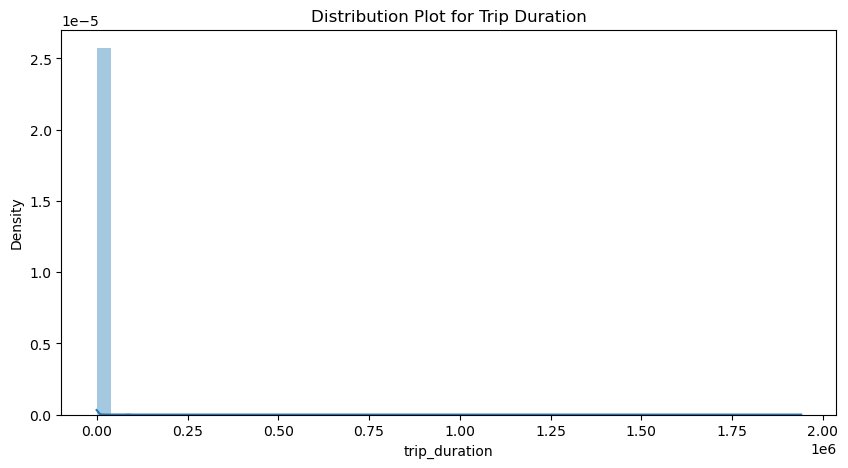

In [14]:
#Dependent variable 'trip_duration'
plt.figure(figsize=(10,5))
sns.distplot(data['trip_duration']).set(title='Distribution Plot for Trip Duration')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14152\3461812076.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(data['trip_duration'])).set(title='Distribution Plot with Log Transformation for Trip Duration')


[Text(0.5, 1.0, 'Distribution Plot with Log Transformation for Trip Duration')]

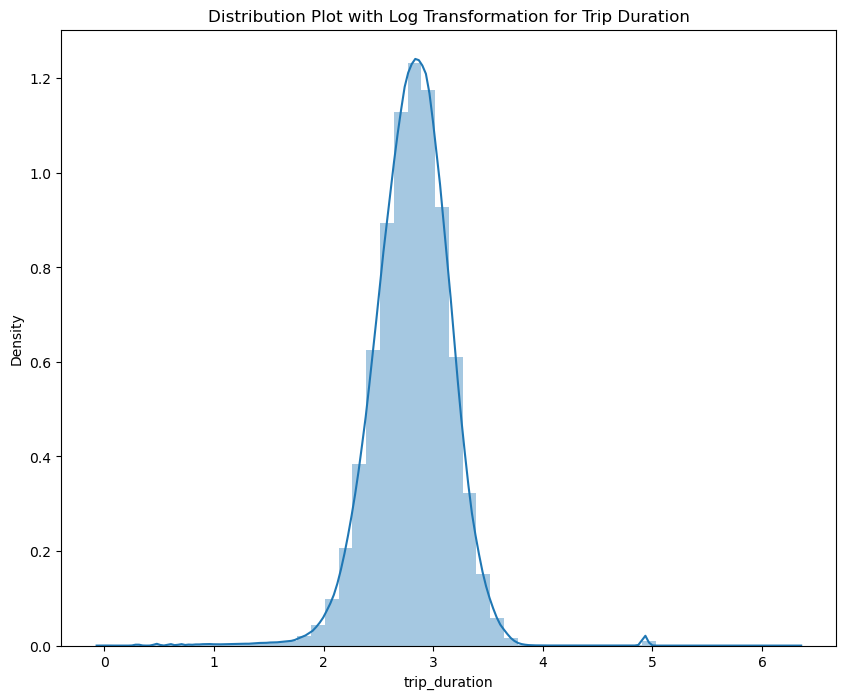

In [15]:
plt.figure(figsize=(10,8))
sns.distplot(np.log10(data['trip_duration'])).set(title='Distribution Plot with Log Transformation for Trip Duration')

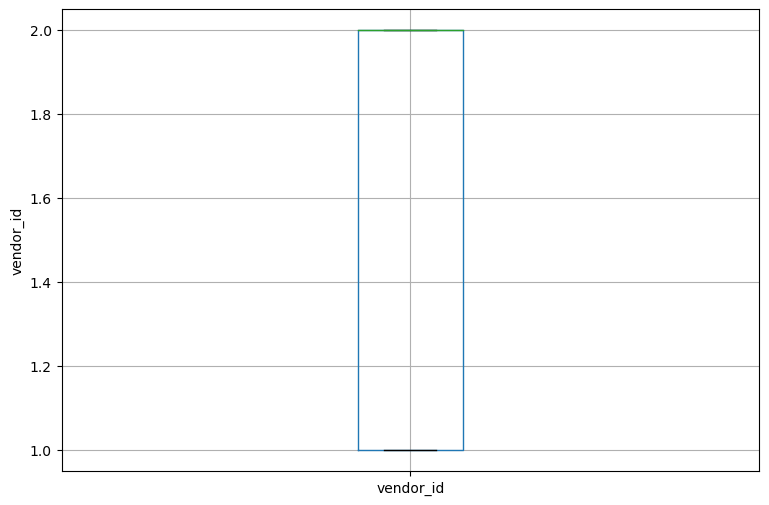

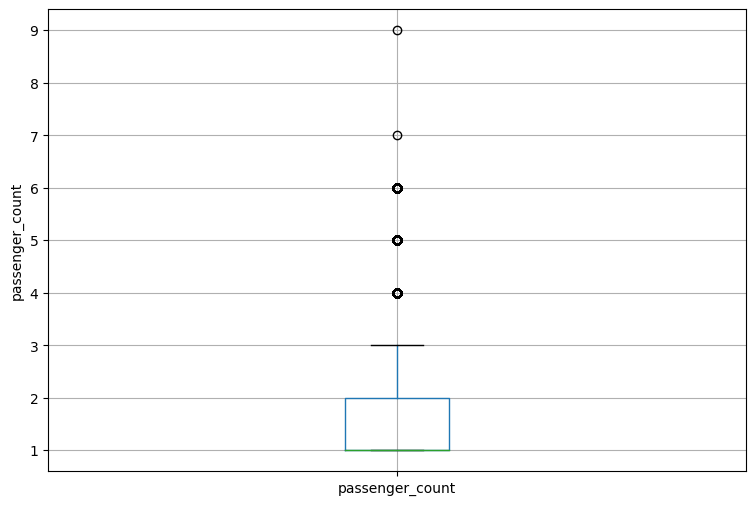

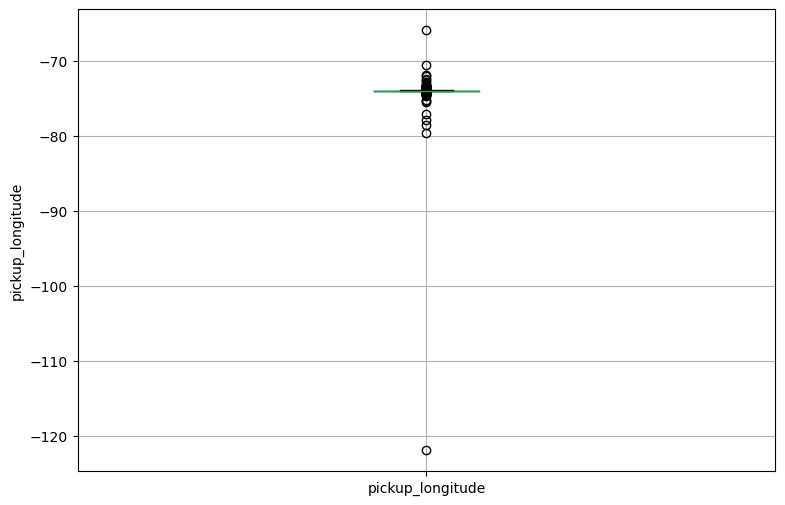

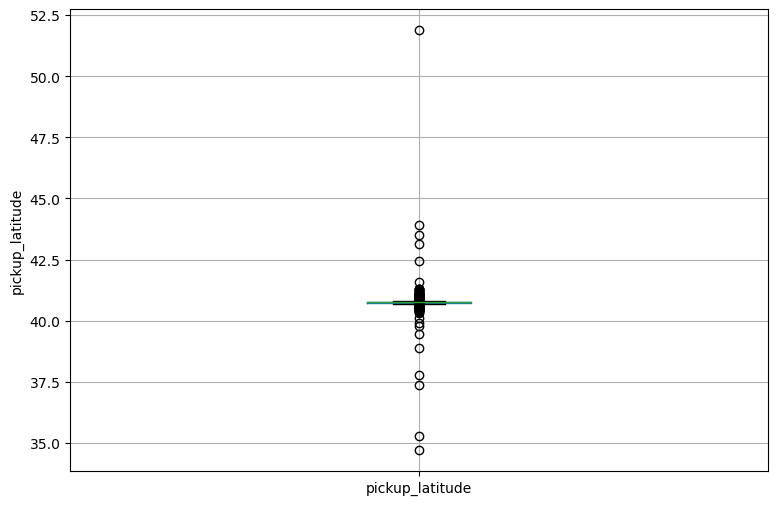

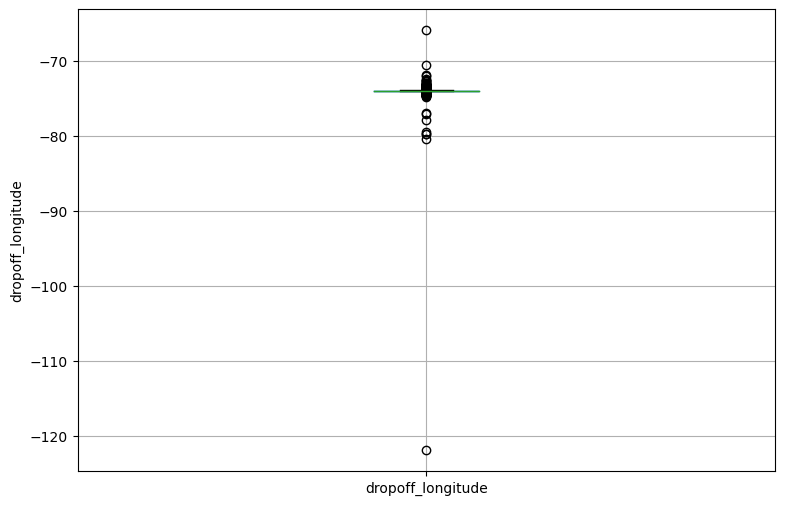

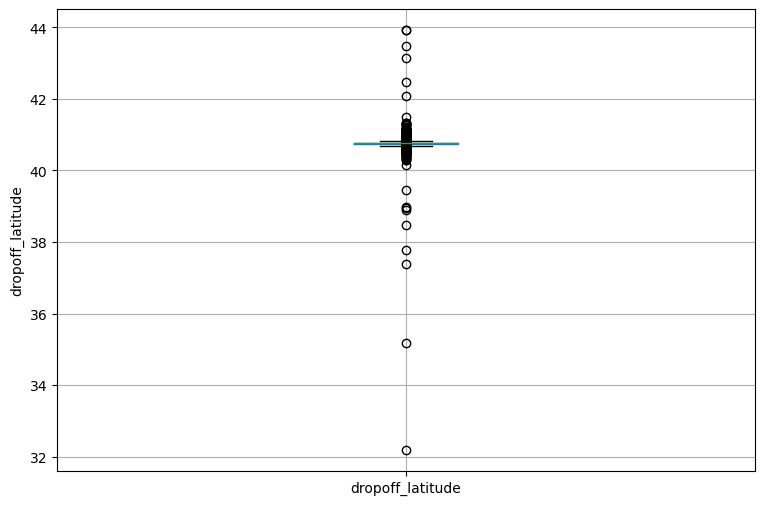

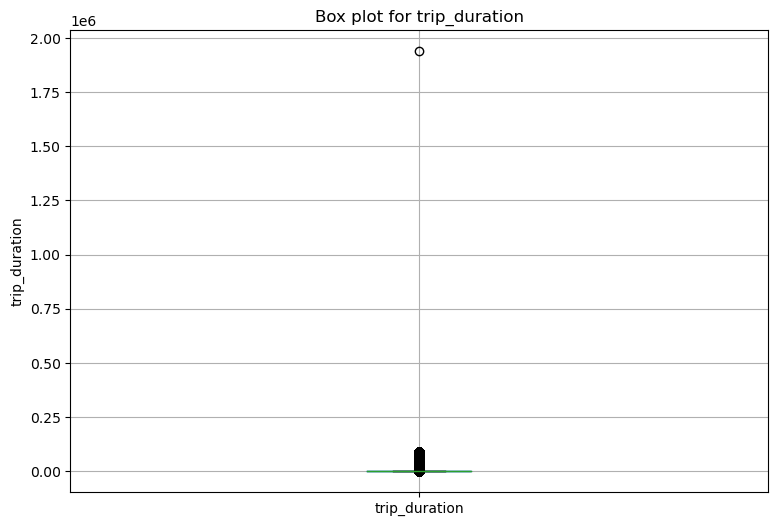

In [16]:
# plot a boxplot for the label by each numerical feature  
for col in data.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  data.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.title("Box plot for trip_duration")
plt.show()

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

Checking consitency of trip_duration

from the box plot we see that there are few outlier having very large value. we have to remove those outlier. but first let check the consitency of feature "trip duration". To do so we calculate the difference between pick and dropoff time.

In [17]:
# creating a function that will out trip duration from pick and dropoff time
def calculate_trip_duration(pickup,dropoff):
    return (dropoff-pickup).total_seconds()

In [18]:
# creating a feature which stores this calculated trip duration
data['calculate_trip_duration']=data.apply(lambda x: calculate_trip_duration(x['pickup_datetime'],x['dropoff_datetime']),axis=1)

In [19]:
# checking for consistency by comparing trip duration with calculated trip duration
(data['calculate_trip_duration']==data['trip_duration']).value_counts()

True    729289
dtype: int64

In [20]:
# Dropping the feature created 
data.drop(['calculate_trip_duration'],axis=1,inplace=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'less then 1min'),
  Text(1, 0, 'within 10 mins'),
  Text(2, 0, 'within 30 mins'),
  Text(3, 0, 'within hour'),
  Text(4, 0, 'within day'),
  Text(5, 0, 'within two days'),
  Text(6, 0, 'more then two day')])

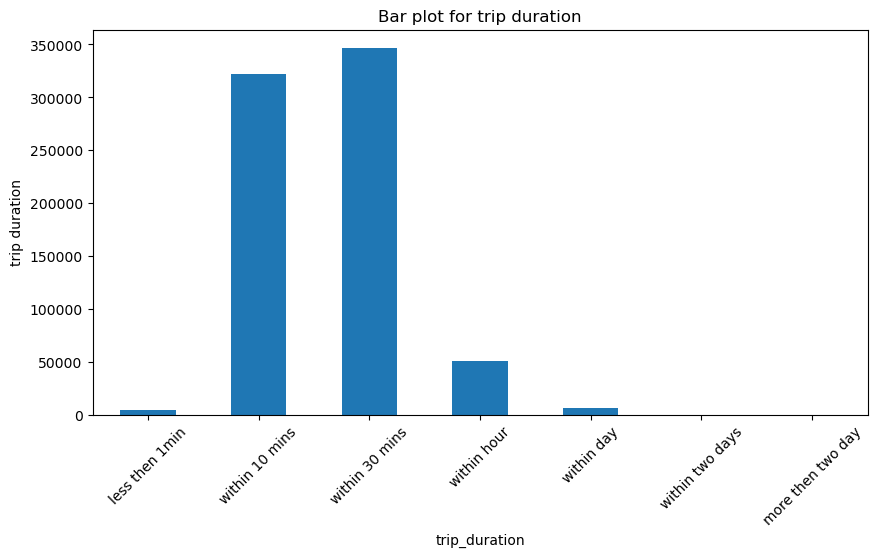

In [21]:
# segregrating the dependent variable into different categories.
plt.figure(figsize=[10,5])
labels=['less then 1min','within 10 mins','within 30 mins','within hour','within day','within two days','more then two day']
data.groupby(pd.cut(data['trip_duration'],bins=[0,60,600,1800,3600,86400,86400*2,10000000],labels=labels))['trip_duration'].count().plot(kind='bar',fontsize=10)
plt.title("Bar plot for trip duration")
plt.ylabel("trip counts")
plt.ylabel("trip duration")
plt.xticks(rotation=45)

In [22]:
numeric_features = data.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

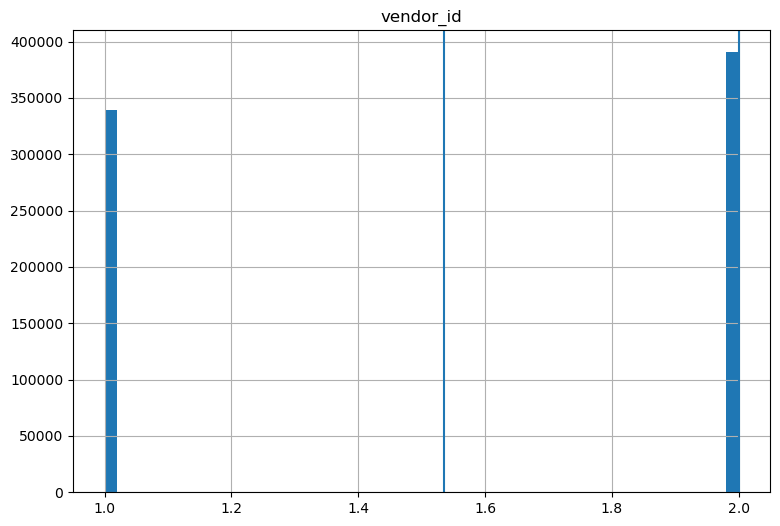

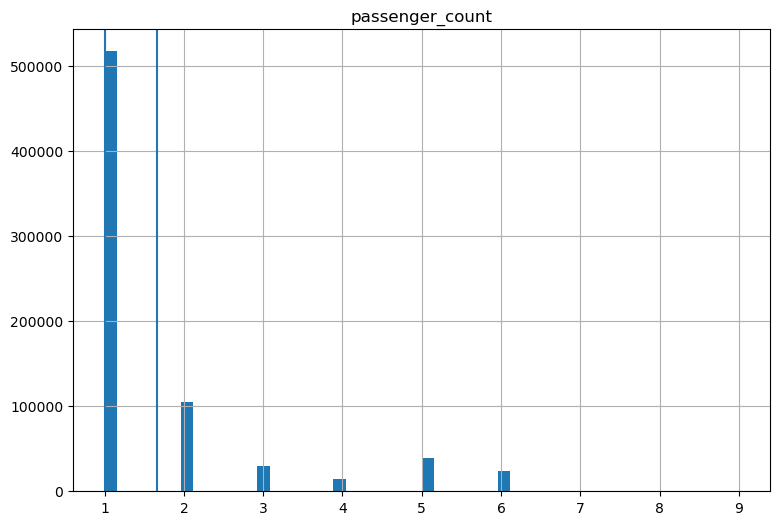

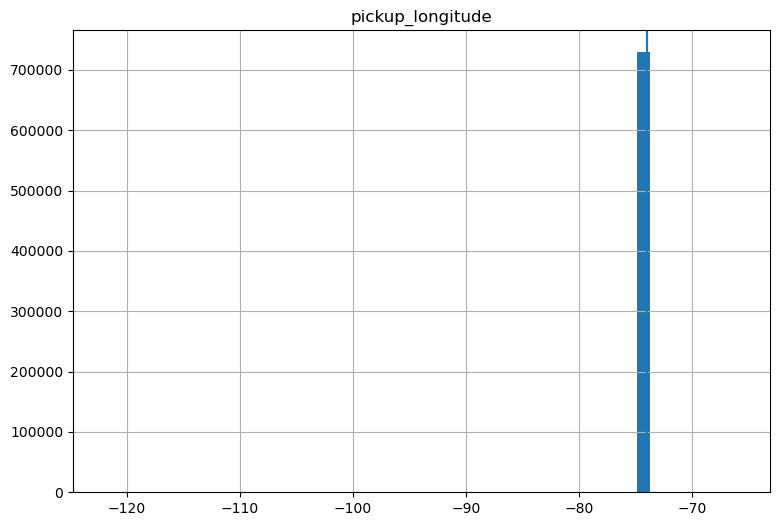

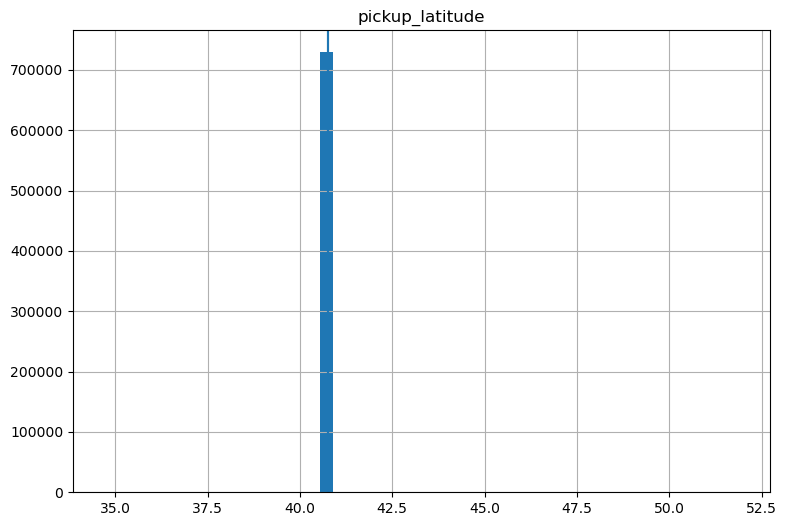

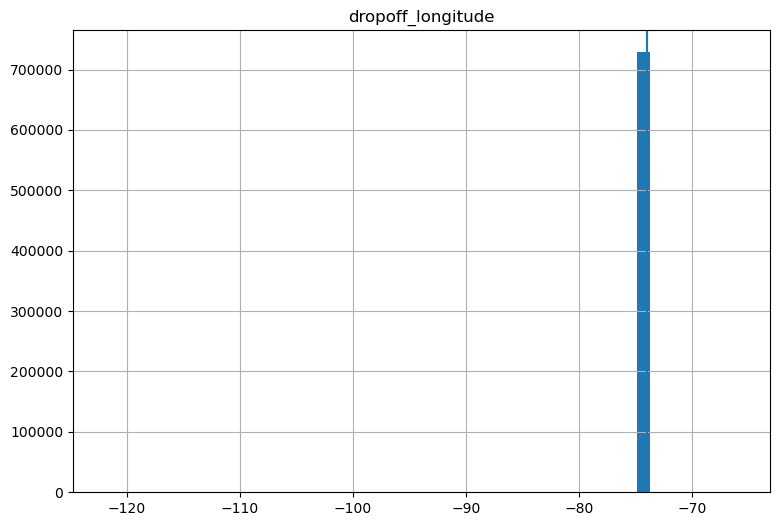

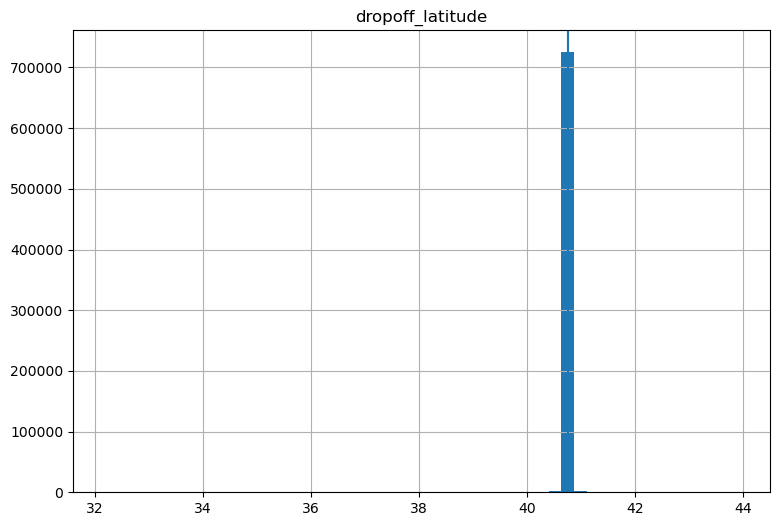

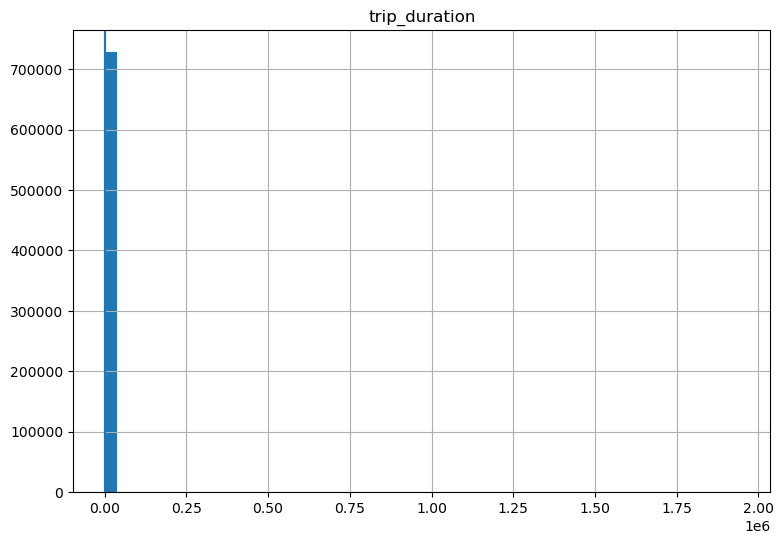

In [23]:
# plot a bar plot for each numerical feature count
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean())
    ax.axvline(feature.median())    
    ax.set_title(col)
plt.show()

In [24]:
data.describe().columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

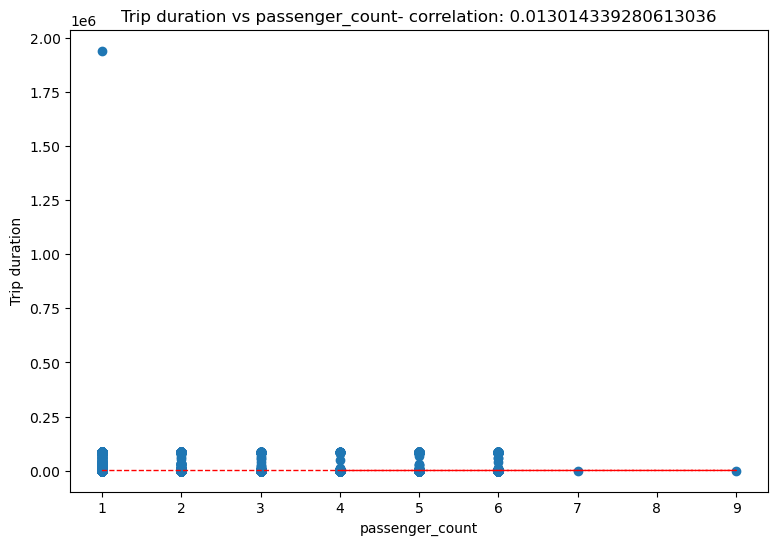

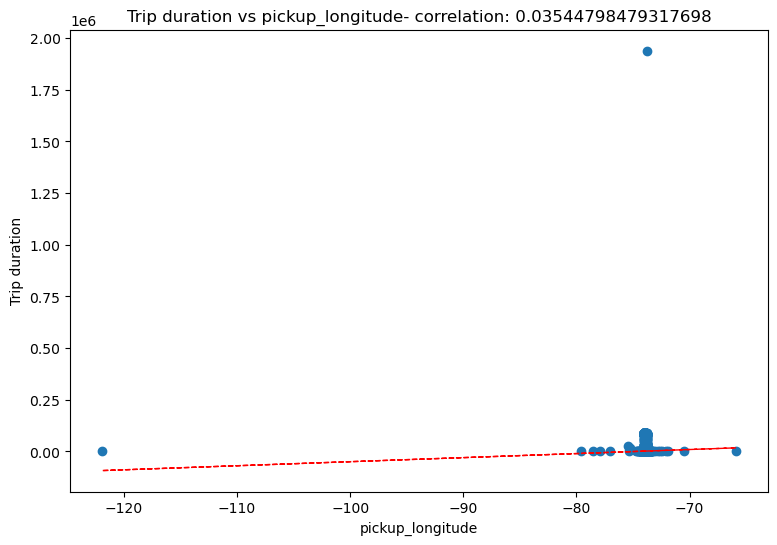

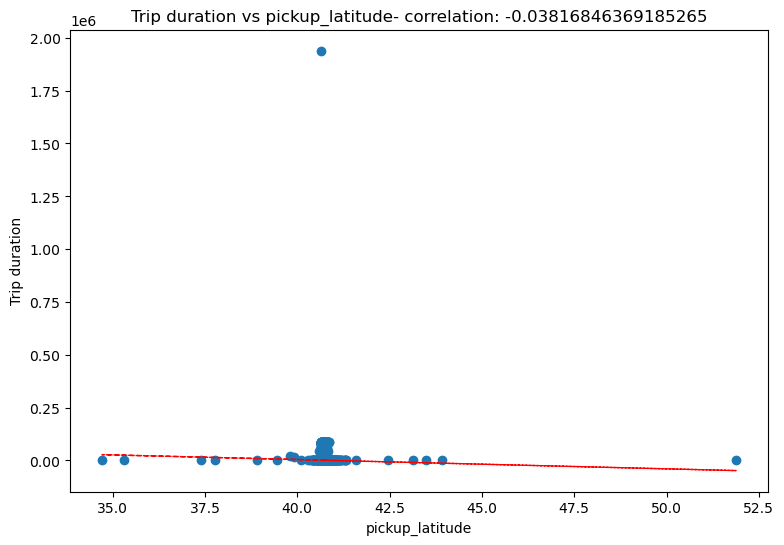

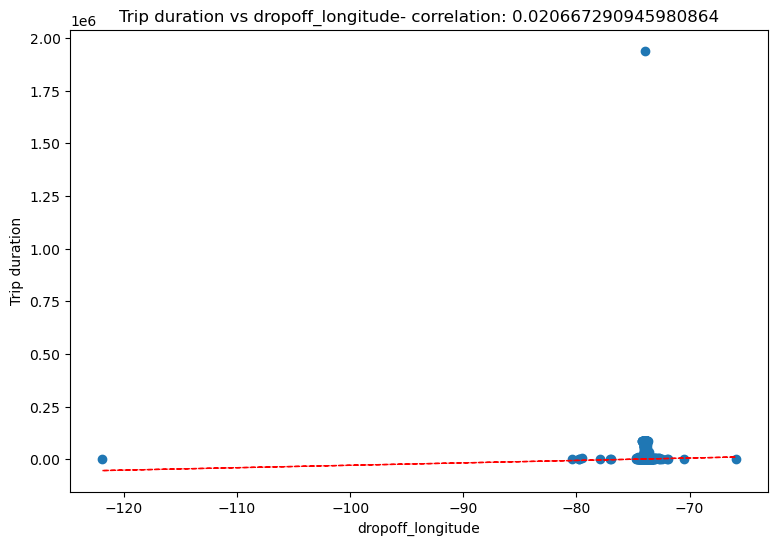

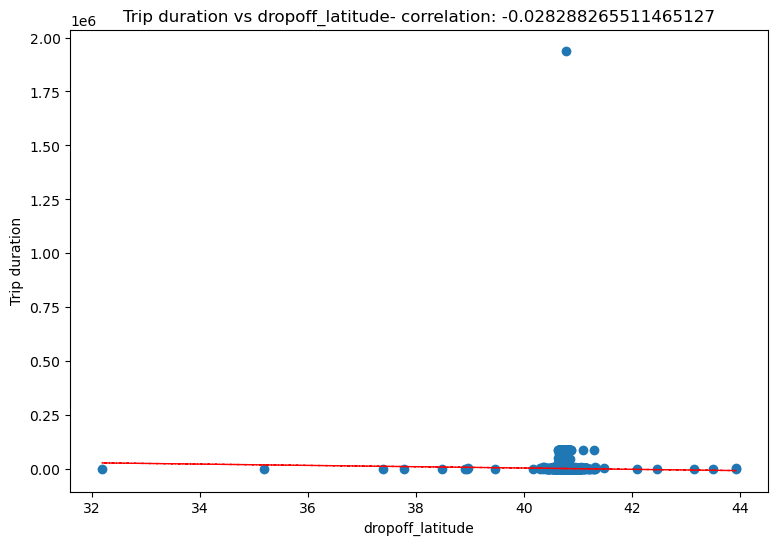

In [25]:

for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    label = data['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip duration')
    ax.set_title('Trip duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(data[col], data['trip_duration'], 1)
    y_hat = np.poly1d(z)(data[col])

    plt.plot(data[col], y_hat, "r--", lw=1)

plt.show()

 ### FEATURE ENGINEERING

Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy.

In [26]:
#Calculate and assign new columns to the dataframe such as pickupday,
#dropoffday which will help us to gain more insights from the data.
data['pickup_day']=data['pickup_datetime'].dt.day_name()
data['dropoff_day']=data['dropoff_datetime'].dt.day_name()
data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784          2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912          2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273          2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939          1 2016-02-17 06:42:23 2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_day dropoff_day  
0         40.771164                  N            400     Monday      Monday  
1         40.694931                  N           1100     Friday      Friday  
2         40.774918                  N           1635     Sunday      Sunday  
3         40.780628                  N           1141    Tuesday     Tuesday  
4         40.740631                  N            848  Wednesday   Wednesday

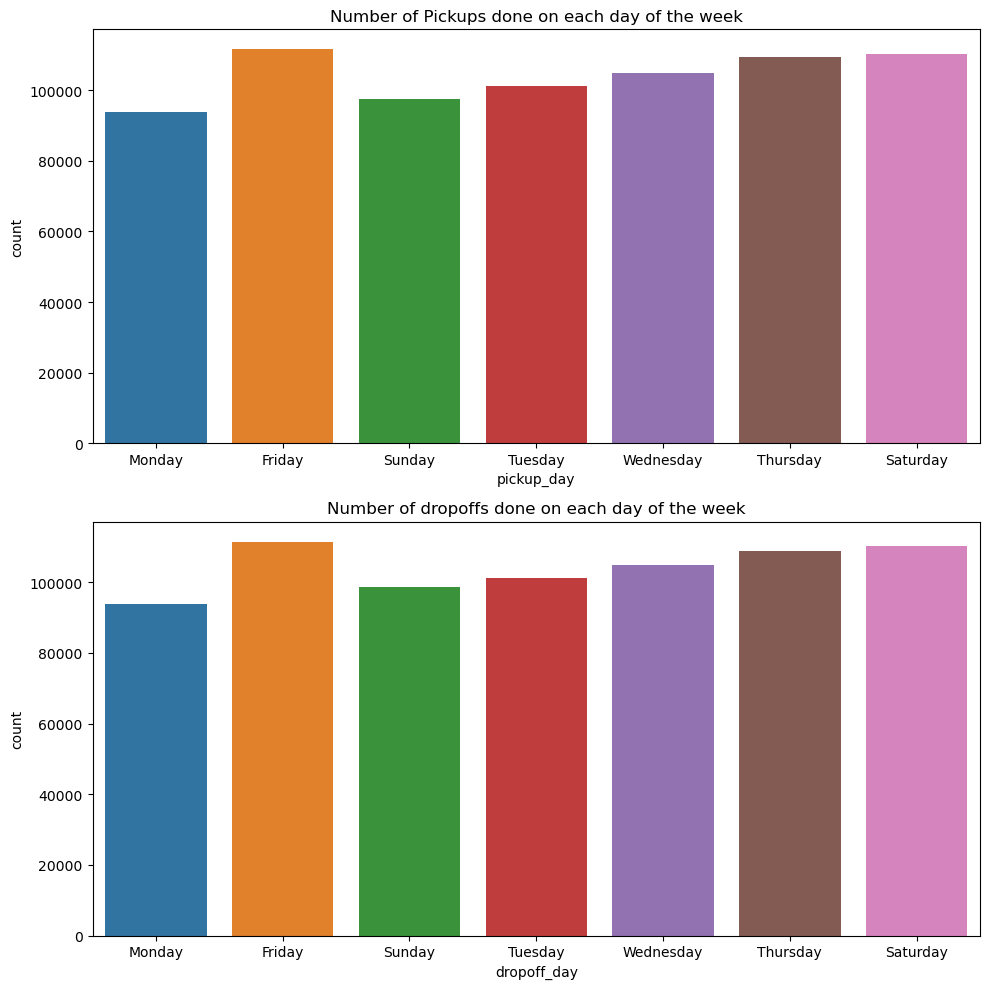

In [27]:
data#Number of Pickups and Dropoff on each day of the week
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=data,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=data,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')

plt.tight_layout()

Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.

In [28]:
bins=np.array([0,1800,3600,5400,7200,90000])
data['duration_time']=pd.cut(data.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [29]:
import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
data['pickup_timezone']=data['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
data['dropoff_timezone']=data['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

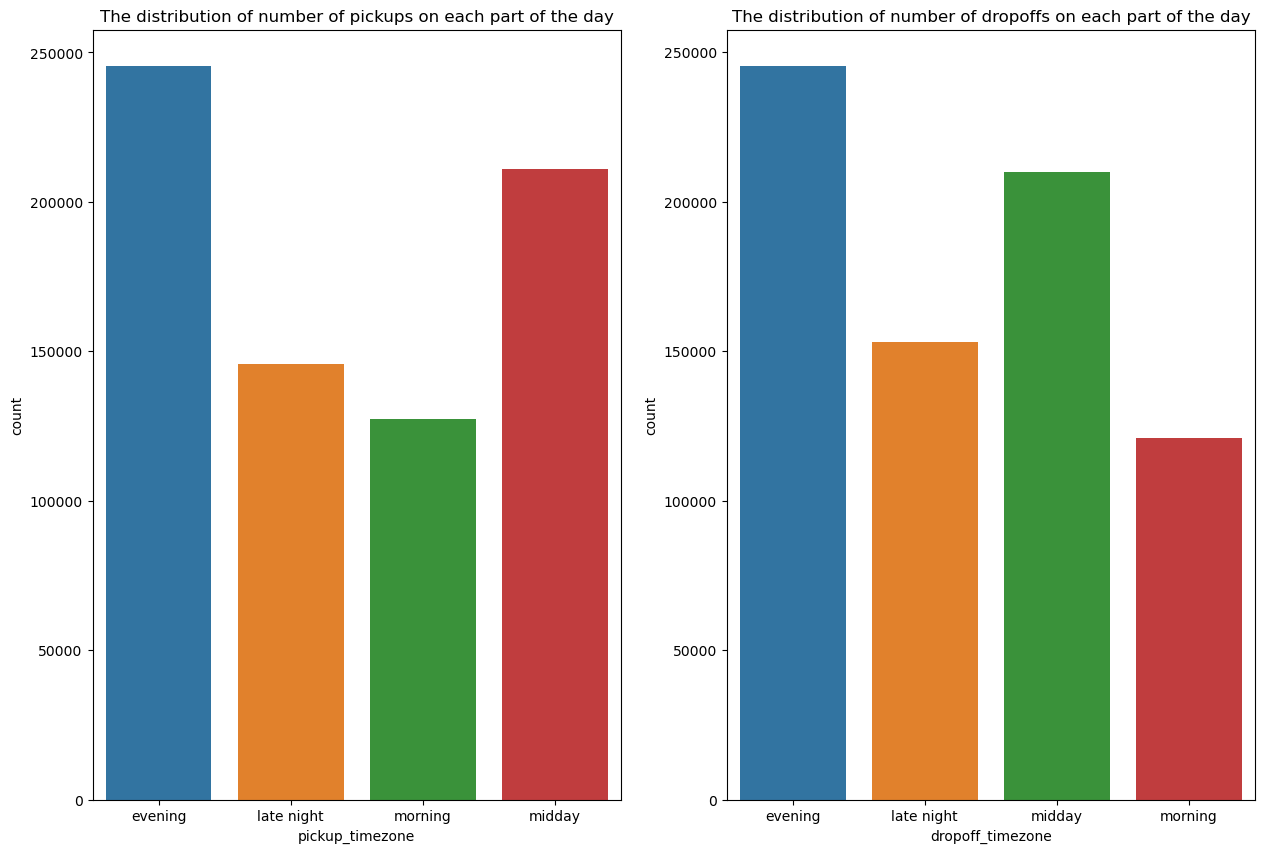

In [30]:
# Distribution of the no of Pickups and Dropoffs in a day
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=data,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=data,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

In [31]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [32]:
#Calculate distance and assign new column to the dataframe.
data["distance"] = data.apply(lambda x: calc_distance(x),axis=1)

### Outlier Detection using IQR Method


IQR=Q3-Q1

lower_limit_outlier=Q1-1.5*IQR

upper_limit_outlier=Q3+1.5*IQR¶

so we have to take the values which is greater then lower limit outlier and less then upper limit outlier
remove the outlier present in distance

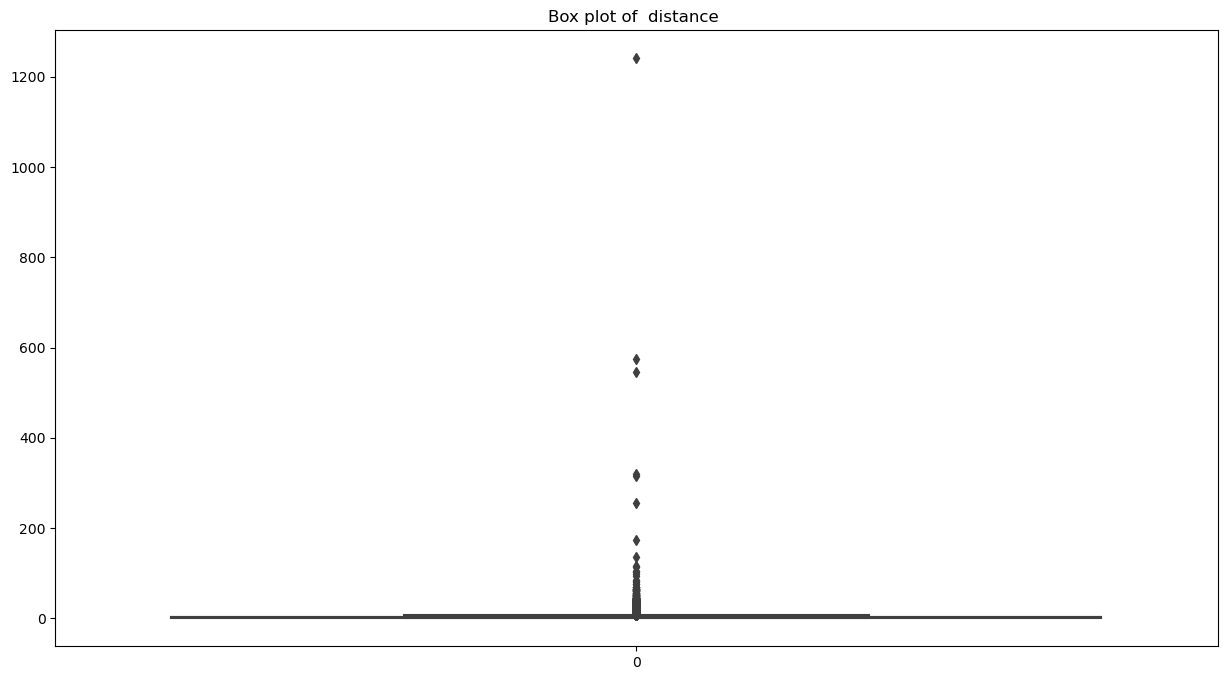

In [33]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=data['distance'])

In [34]:
q1 = np.percentile(data['distance'],25)
print(q1)
q2 = np.percentile(data['distance'],50)
print(q2)
q3 = np.percentile(data['distance'],75)
print(q3)

1.2327600271363433
2.0957833089792643
3.876520575111666


In [35]:
iqr=q3 - q1
lower_limit_outlier=q1-1.5*iqr
upper_limit_outlier=q3+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.732880794826641
Upper limit for outlier  : 7.84216139707465


In [36]:
data=data[data['distance']>lower_limit_outlier]
data=data[data['distance']<upper_limit_outlier]

In [37]:
data.shape

(658973, 17)

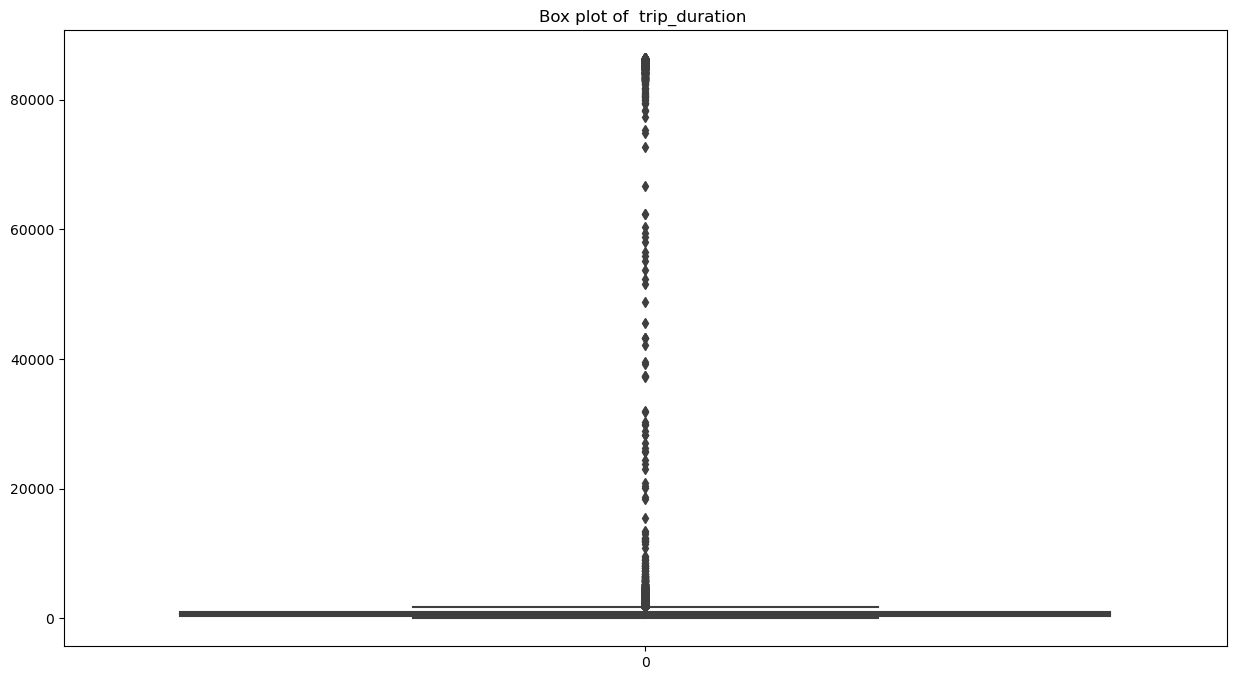

In [38]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=data['trip_duration'])

In [39]:
q1_trip_duration = np.percentile(data['trip_duration'],25)
print(q1_trip_duration)
q2_trip_duration = np.percentile(data['trip_duration'],50)
print(q2_trip_duration)
q3_trip_duration = np.percentile(data['trip_duration'],75)
print(q3_trip_duration)

373.0
606.0
932.0


In [40]:

iqr=q3_trip_duration - q1_trip_duration
lower_limit_outlier_trip_duration=q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=q3_trip_duration+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

lower limit for outlier  : -465.5
Upper limit for outlier  : 1770.5


In [41]:

data=data[data['trip_duration']>0]
data=data[data['trip_duration']<upper_limit_outlier_trip_duration]

In [42]:
data.shape

(638812, 17)

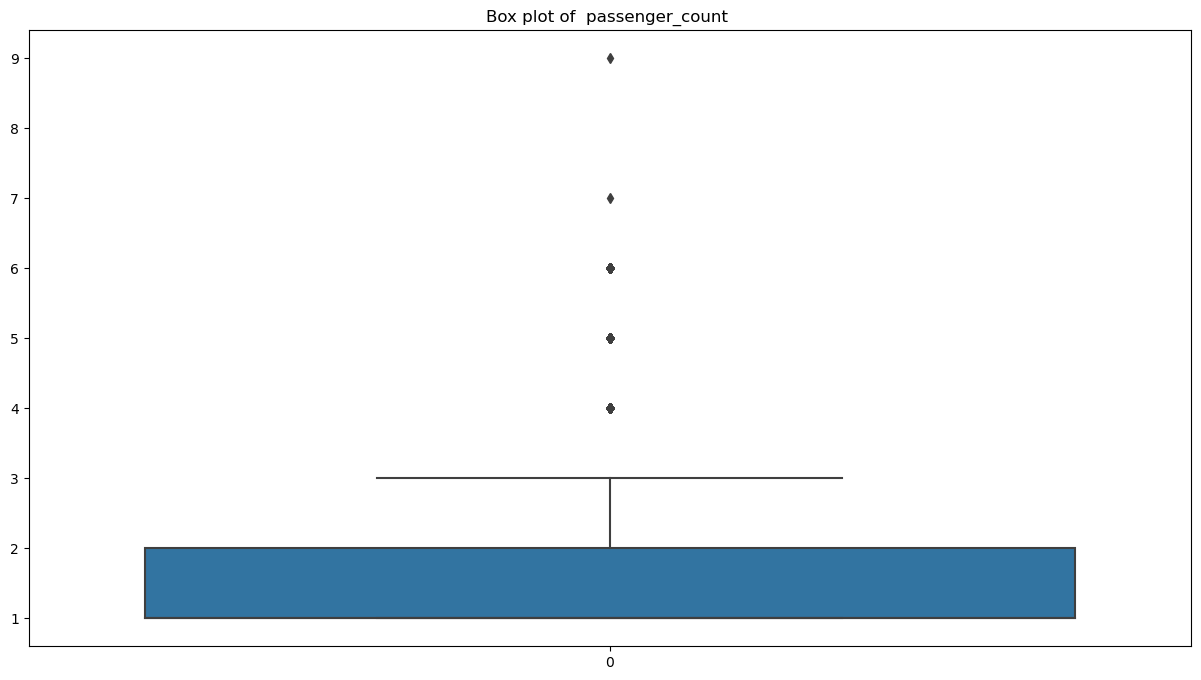

In [43]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=data['passenger_count'])

In [44]:
q1_passenger_count = np.percentile(data['passenger_count'],25)
print(q1_passenger_count)
q2_passenger_count = np.percentile(data['passenger_count'],50)
print(q2_passenger_count)
q3_passenger_count = np.percentile(data['passenger_count'],75)
print(q3_passenger_count)

1.0
1.0
2.0


In [45]:
iqr=q3_passenger_count - q1_passenger_count
lower_limit_outlier_passenger_count=q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=q3_passenger_count+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [46]:

data=data[data['passenger_count']>0]
data=data[data['passenger_count']<upper_limit_outlier_passenger_count]

In [47]:
data.shape

(571694, 17)

In [48]:
#convert dattime in "%Y-%m-%d %H:%M:%S" format
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [49]:
data['Day']=data['pickup_datetime'].dt.day_name()

In [50]:
data#Calculate and assign new columns to the dataframe such as year,
#month ,day_num,hour and minute which will help us to gain more insights from the data.
data["year"] = data["pickup_datetime"].apply(lambda x: x.year)
data["month"] = data["pickup_datetime"].apply(lambda x: x.month)
data["day_num"] = data["pickup_datetime"].apply(lambda x: x.day)
data["hour"] = data["pickup_datetime"].apply(lambda x: x.hour)
data["minute"] = data["pickup_datetime"].apply(lambda x: x.minute)

In [51]:
data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784          2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912          2 2016-02-21 17:59:33 2016-02-21 18:26:48   
4  id0232939          1 2016-02-17 06:42:23 2016-02-17 06:56:31   
5  id1918069          2 2016-02-14 18:31:42 2016-02-14 18:55:57   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
4                1        -74.017120        40.708469         -73.988182   
5                2        -73.993614        40.751884         -73.995422   

   dropoff_latitude store_and_fwd_flag  ...  duration_time pickup_timezone  \
0         40.771164                  N  ...            < 5         evening   
1         40.694931                  N  ...            < 5      late night   
2         40.774918                  N  ...            < 5         evening   
4         40.740631                  N  ...            < 5         morning   
5         40.723862                  N  ...            < 5         evening   

  dropoff_timezone  distance        Day  year  month day_num  hour  minute  
0          evening  1.199074     Monday  2016      2      29    16      40  
1       late night  4.129117     Friday  2016      3      11    23      35  
2          evening  7.250763     Sunday  2016      2      21    17      59  
4          morning  4.328540  Wednesday  2016      2      17     6      42  
5          evening  3.119716     Sunday  2016      2      14    18      31  

[5 rows x 23 columns]

Converting trip duration into hours.

Taking log of our distance for normalisation of data.

Taking log of our trip duration as well to normalize it's data too.

In [52]:
data['trip_duration_hour']=data['trip_duration']/3600
data['log_distance']=np.log(data.distance)
data['log_trip_duration']=np.log(data.trip_duration_hour)

C:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='vendor_id', ylabel='count'>

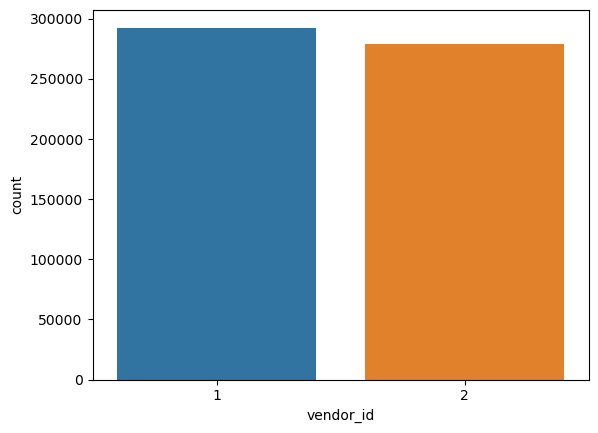

In [53]:
#Distribution of the vendor id for the taxi trip
sns.countplot(x='vendor_id',data=data)

<a id=bivariate></a>
# Bivariate Analysis
***
Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.


<Axes: xlabel='distance', ylabel='trip_duration'>

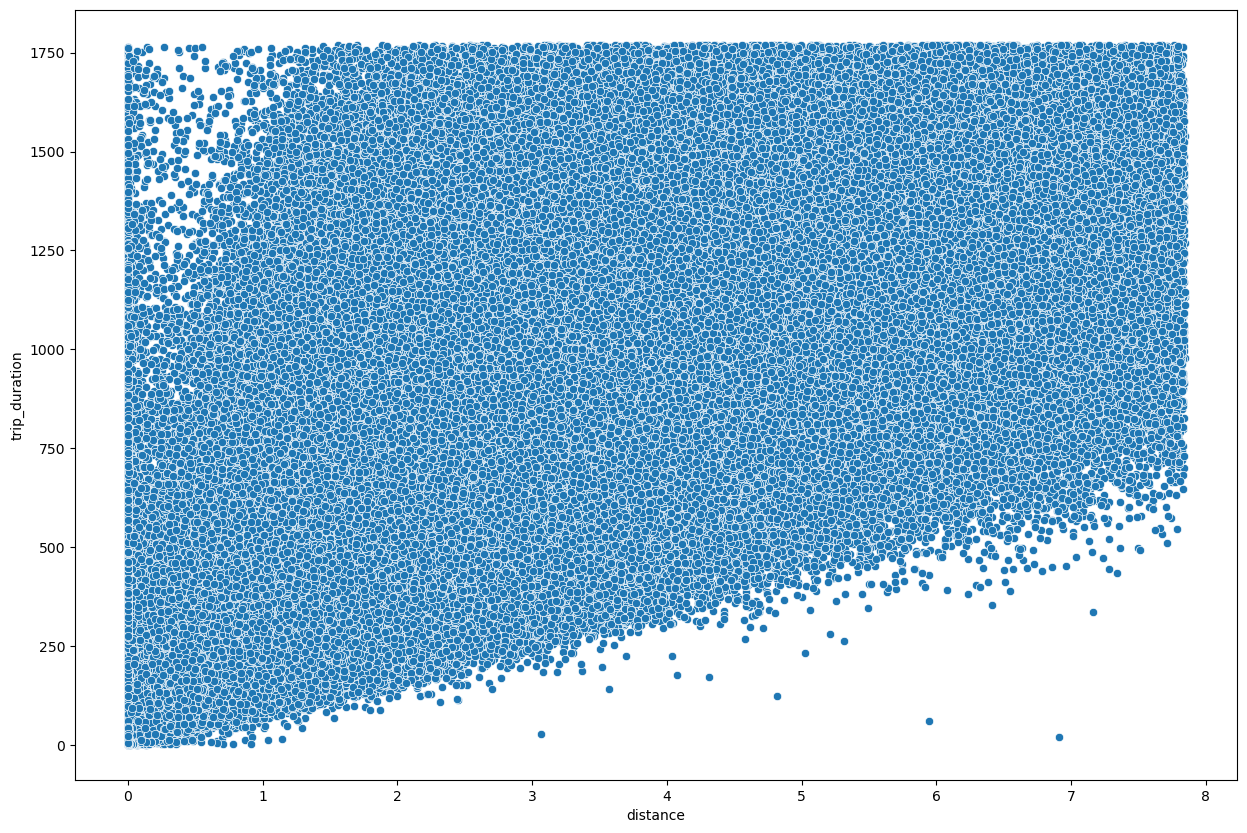

In [54]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='distance',y='trip_duration',data=data)

<Axes: xlabel='log_distance', ylabel='log_trip_duration'>

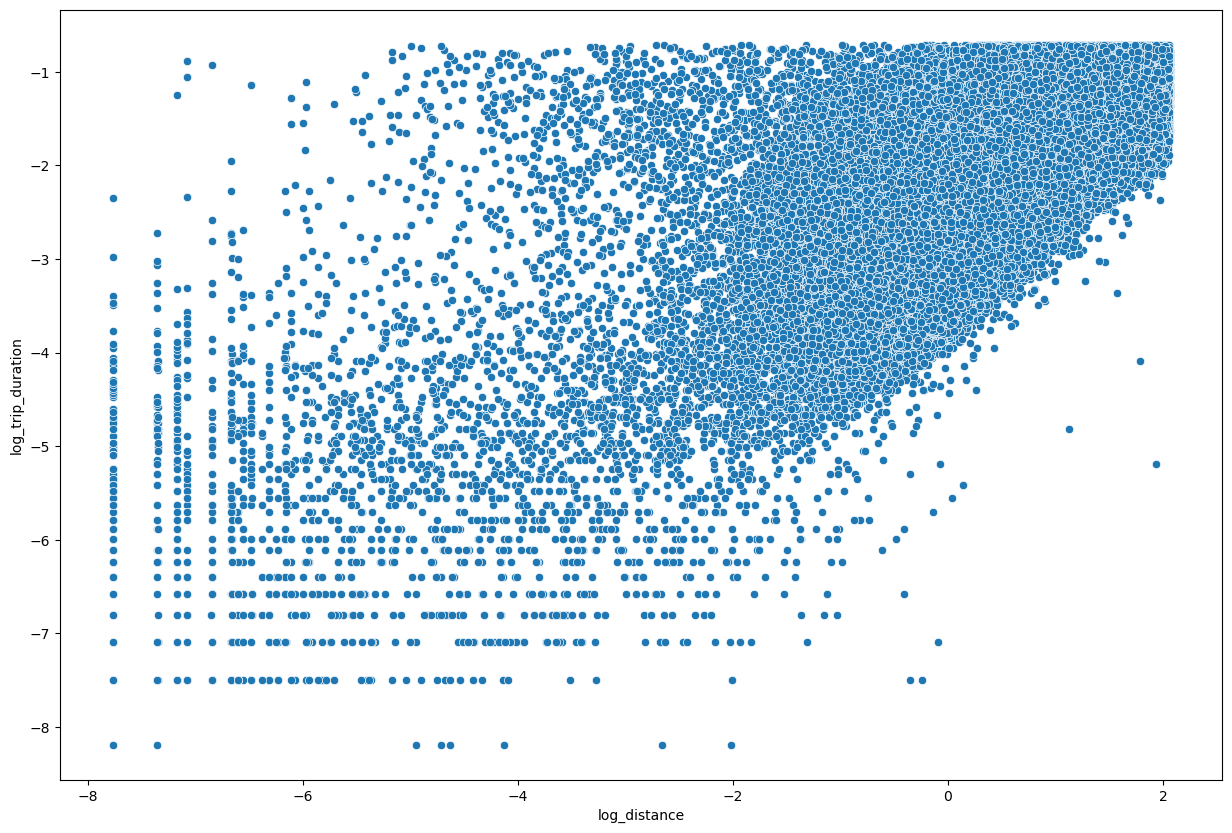

In [55]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='log_distance',y='log_trip_duration',data=data)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14152\343236803.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[i],color="g")
C:\Users\lenovo\AppData\Local\Temp\ipykernel_14152\343236803.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[i],color="g")


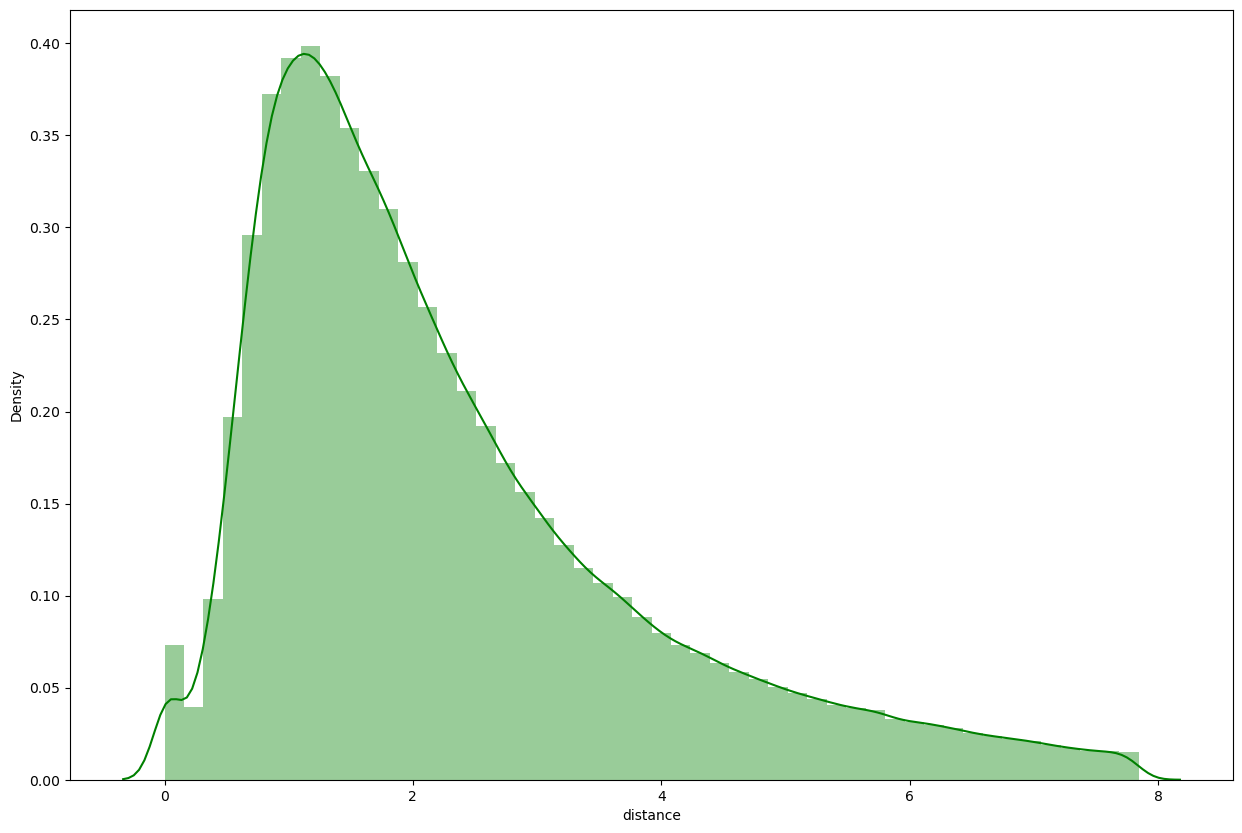

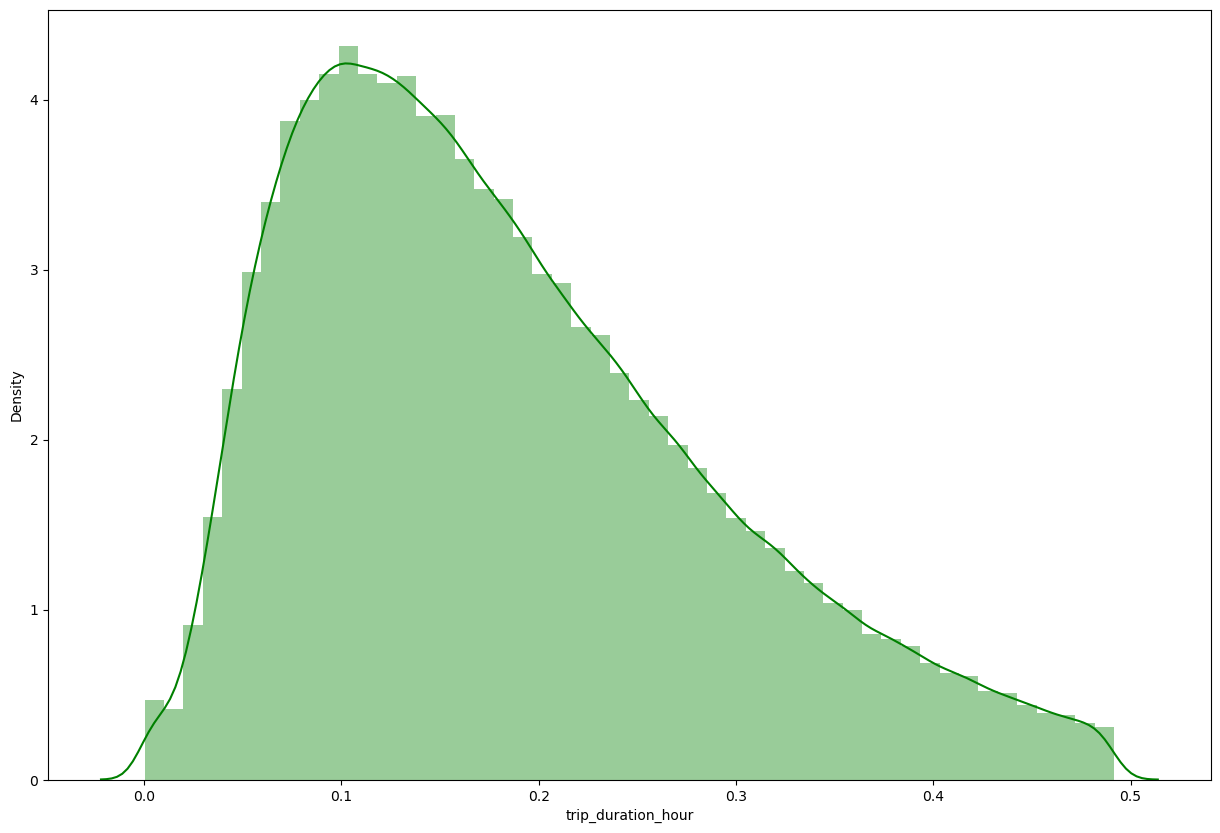

In [56]:
sample=['distance','trip_duration_hour']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(data[i],color="g")

In [57]:
#Dummify all the categorical features like "store_and_fwd_flag, Day" except the label i.e. "trip_duration"
data= pd.get_dummies(data, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [58]:
#Feature for the Machine learning models
features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [59]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_data=data[newdata]

In [60]:
data.shape

(571694, 33)

### Split Data

Lets split our data first before scaling the features

In [61]:
#For Standarization  apply z-score
from scipy.stats import zscore
#Train test split
X = data[features].apply(zscore)[:100000]
y=data['trip_duration_hour'][:100000]

In [62]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [64]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)


<a id=heatmap></a>
## Heatmap
***



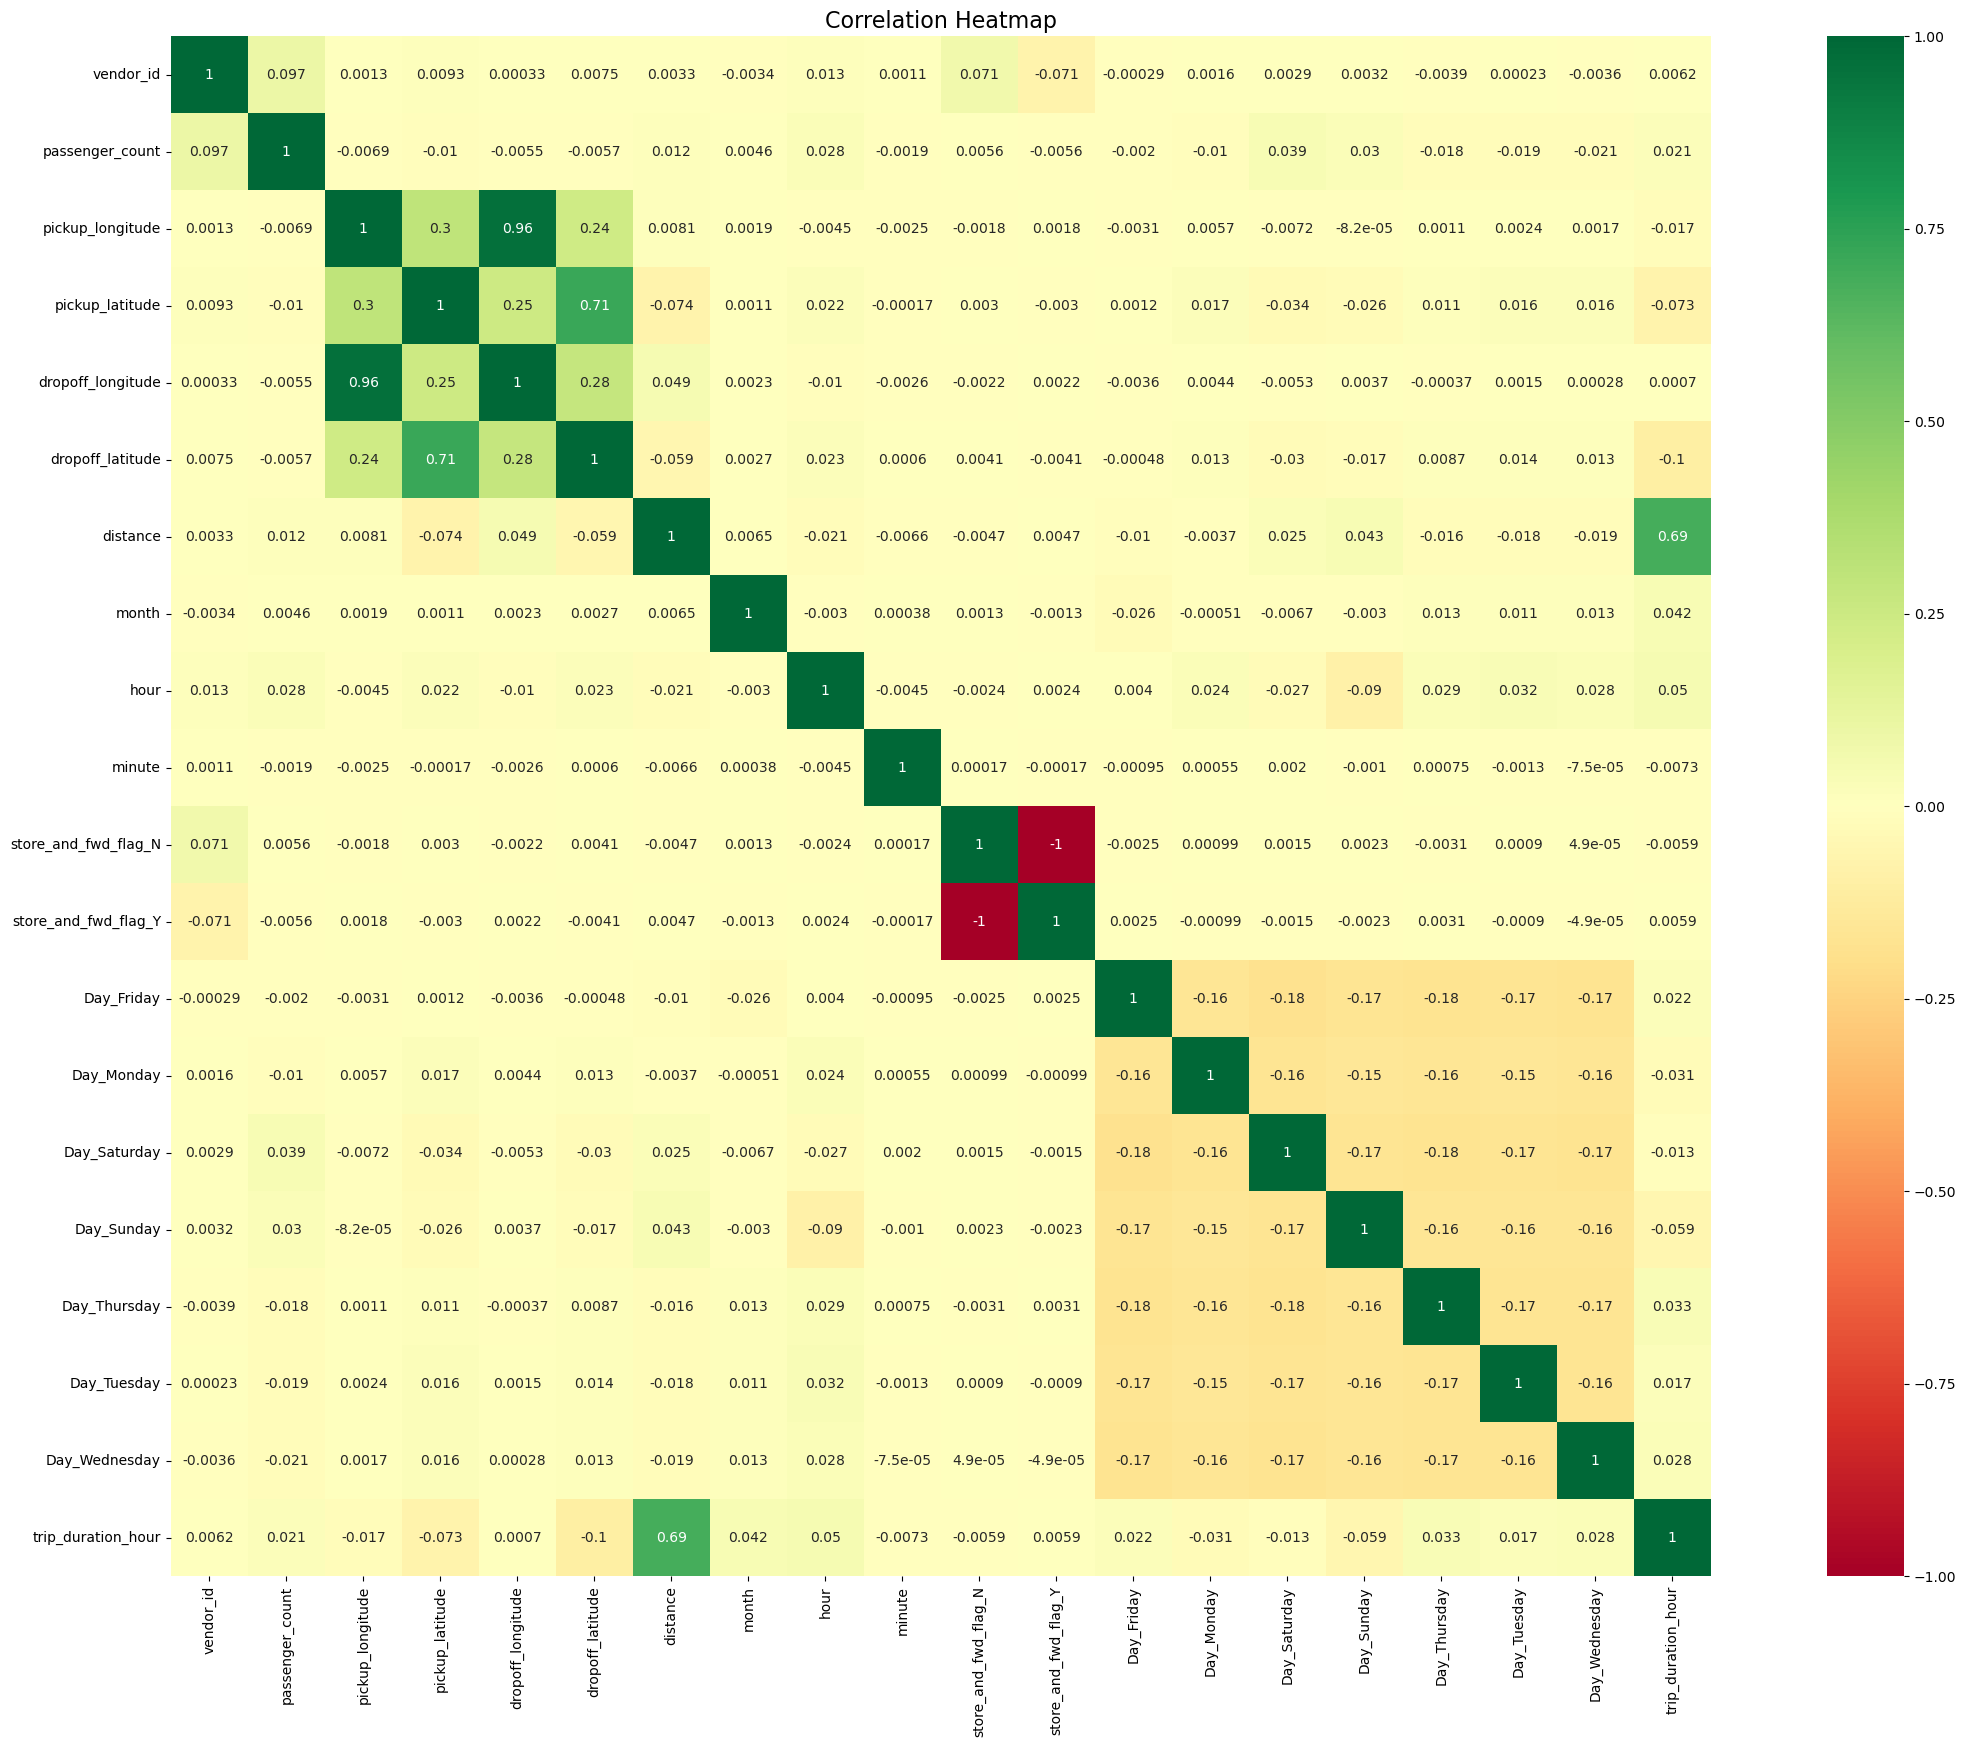

In [65]:
plt.figure (figsize= (30,20))

sns.heatmap(trip_data.corr(), cmap='RdYlGn', annot=True,vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [66]:
from matplotlib import legend
# Function for evaluation metric for regression
def EvaluationMetric(Xt,yt,yp,disp="on"):
  ''' Take the different set of parameter and prints evaluation metrics '''
  MSE=round(mean_squared_error(y_true=yt,y_pred=yp),4)
  RMSE=(np.sqrt(MSE))
  R2=(r2_score(y_true=yt,y_pred=yp))
  Adjusted_R2=(1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)))
  if disp=="on":
    print("MSE :",MSE,"RMSE :", RMSE)
    print("R2 :",R2,"Adjusted R2 :",Adjusted_R2)

  #Plotting Actual and Predicted Values
  plt.figure(figsize=(18,6))
  plt.plot((yp)[:100]) 
  plt.plot((np.array(yt)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Time Duration')


  
  return (MSE,RMSE,R2,Adjusted_R2) 


### Linear Regression

Linear regression analysis is used to predict the value of a variable based on the value of another variable. The variable you want to predict is called the dependent variable. The variable you are using to predict the other variable's value is called the independent variable.

In [67]:
# Instance the linear regression object
reg = LinearRegression().fit(X_train, y_train)

In [68]:
reg.score(X_train, y_train)

0.5007105076958794

In [69]:
y_pred_train = reg.predict(X_train)

In [70]:
y_pred_test = reg.predict(X_test)

MSE : 0.0054 RMSE : 0.07348469228349534
R2 : 0.5007105076958794 Adjusted R2 : 0.5005918967887304


(0.0054, 0.07348469228349534, 0.5007105076958794, 0.5005918967887304)

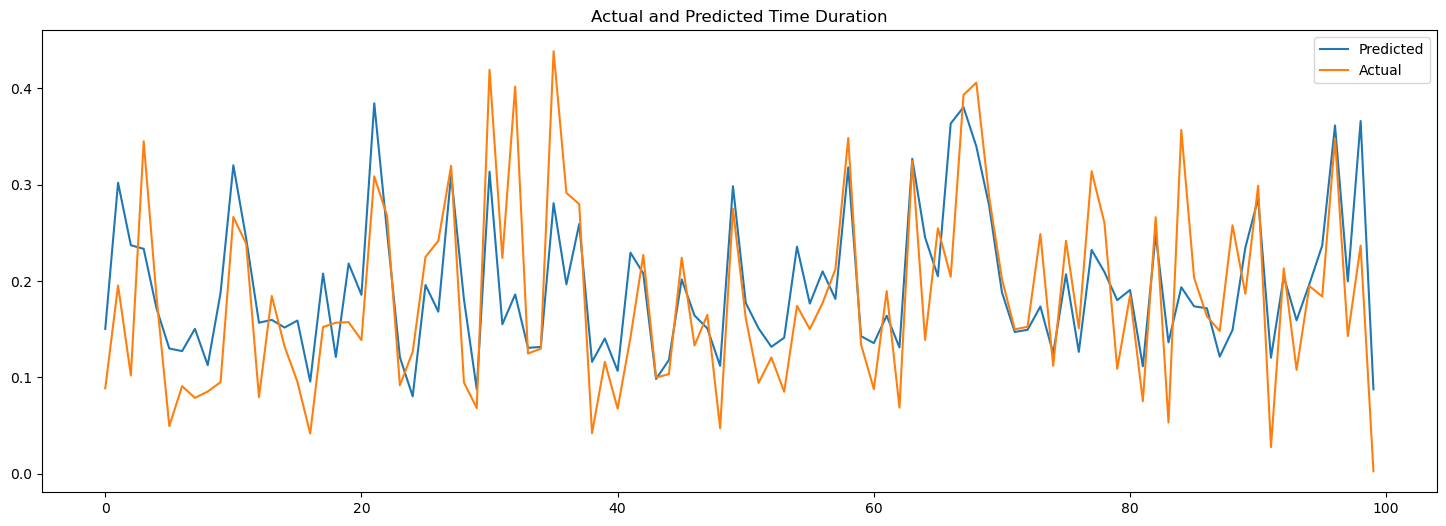

In [71]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_train)



MSE : 0.0056 RMSE : 0.07483314773547883
R2 : 0.4972741440305367 Adjusted R2 : 0.496796076399735


(0.0056, 0.07483314773547883, 0.4972741440305367, 0.496796076399735)

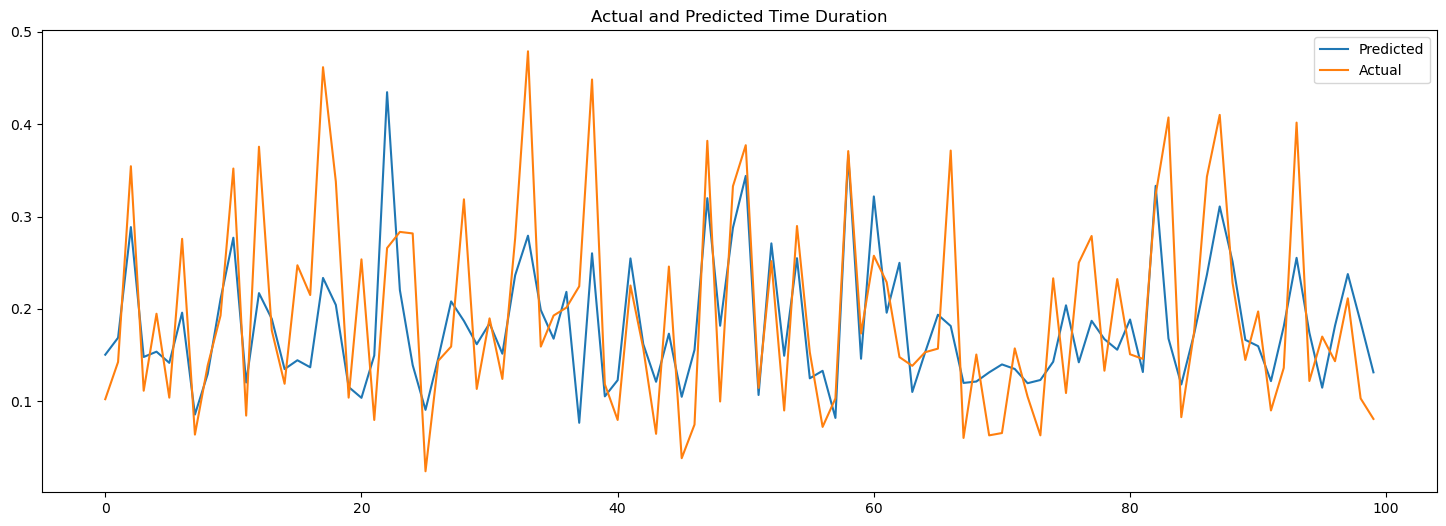

In [72]:
#Evaluation metrics for Test set
EvaluationMetric(X_test,y_test,y_pred_test)

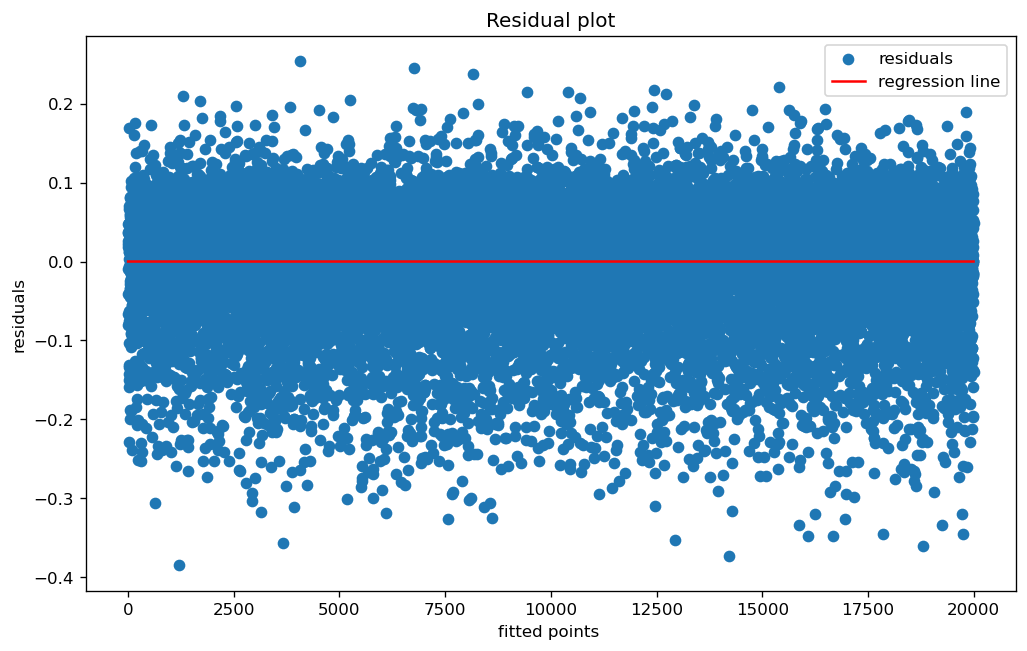

In [73]:
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

### DECISION TREE

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes).

In [74]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,16,20]

# HYperparameter Grid
param_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [75]:
dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=30; total time=   0.2s
[CV] END max_d

[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=20; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=20; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=20; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=30; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=30; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=30; total time=   0.6s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=30; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=30; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=16, min_samples_split=10; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=16, min_samples_split=10; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=16, min_samples_split=10; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=16, min_samples_split=10; total time=

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 16, 20],
                         'min_samples_split': [10, 20, 30]},
             scoring='r2', verbose=2)

In [76]:
dt_grid.best_score_

0.605642555608717

In [77]:
dt_grid.best_score_

0.605642555608717

In [78]:
dt_grid.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=20, min_samples_split=30)

In [79]:
dt_optimal_model =dt_grid.best_estimator_

In [80]:

y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

In [81]:

y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

MSE : 0.0039 RMSE : 0.06244997998398398
R2 : 0.6406423851054879 Adjusted R2 : 0.6405570163297565


(0.0039, 0.06244997998398398, 0.6406423851054879, 0.6405570163297565)

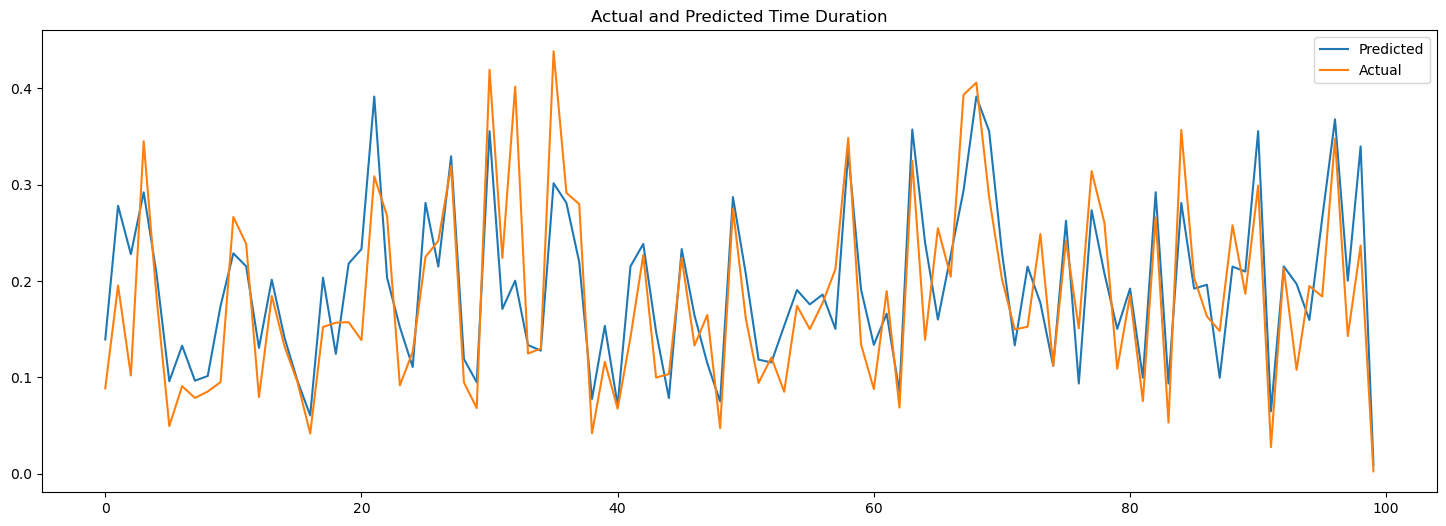

In [82]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_dt_train)

MSE : 0.0043 RMSE : 0.06557438524302
R2 : 0.6117282882672266 Adjusted R2 : 0.6113590609137269


(0.0043, 0.06557438524302, 0.6117282882672266, 0.6113590609137269)

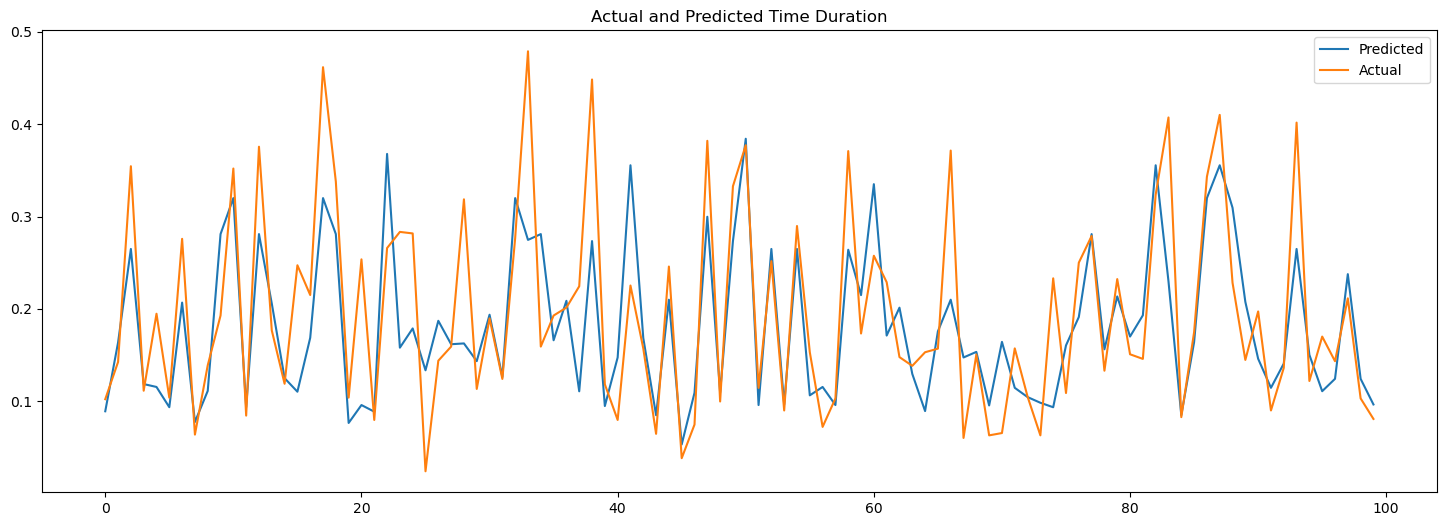

In [83]:
#Evaluation metrics for Test set
EvaluationMetric(X_test,y_test,y_pred_dt_test)

In [84]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [85]:

dt_optimal_model.feature_importances_

array([1.45298511e-03, 4.70556516e-04, 9.15167621e-03, 7.47861588e-03,
       1.02525504e-02, 5.12444480e-02, 7.99115244e-01, 9.08615727e-04,
       8.71394338e-02, 2.12228006e-03, 0.00000000e+00, 0.00000000e+00,
       4.79117293e-04, 1.65828185e-03, 1.15432460e-02, 1.58219250e-02,
       2.72343367e-04, 5.27349102e-04, 3.61331532e-04])

In [86]:

importances = dt_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [87]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
6               distance            0.799115
8                   hour            0.087139
5       dropoff_latitude            0.051244
15            Day_Sunday            0.015822
14          Day_Saturday            0.011543
4      dropoff_longitude            0.010253
2       pickup_longitude            0.009152
3        pickup_latitude            0.007479
9                 minute            0.002122
13            Day_Monday            0.001658
0              vendor_id            0.001453
7                  month            0.000909
17           Day_Tuesday            0.000527
12            Day_Friday            0.000479
1        passenger_count            0.000471
18         Day_Wednesday            0.000361
16          Day_Thursday            0.000272
11  store_and_fwd_flag_Y            0.000000
10  store_and_fwd_flag_N            0.000000

<Axes: title={'center': 'Features importace'}, xlabel='Feature', ylabel='Feature Importance'>

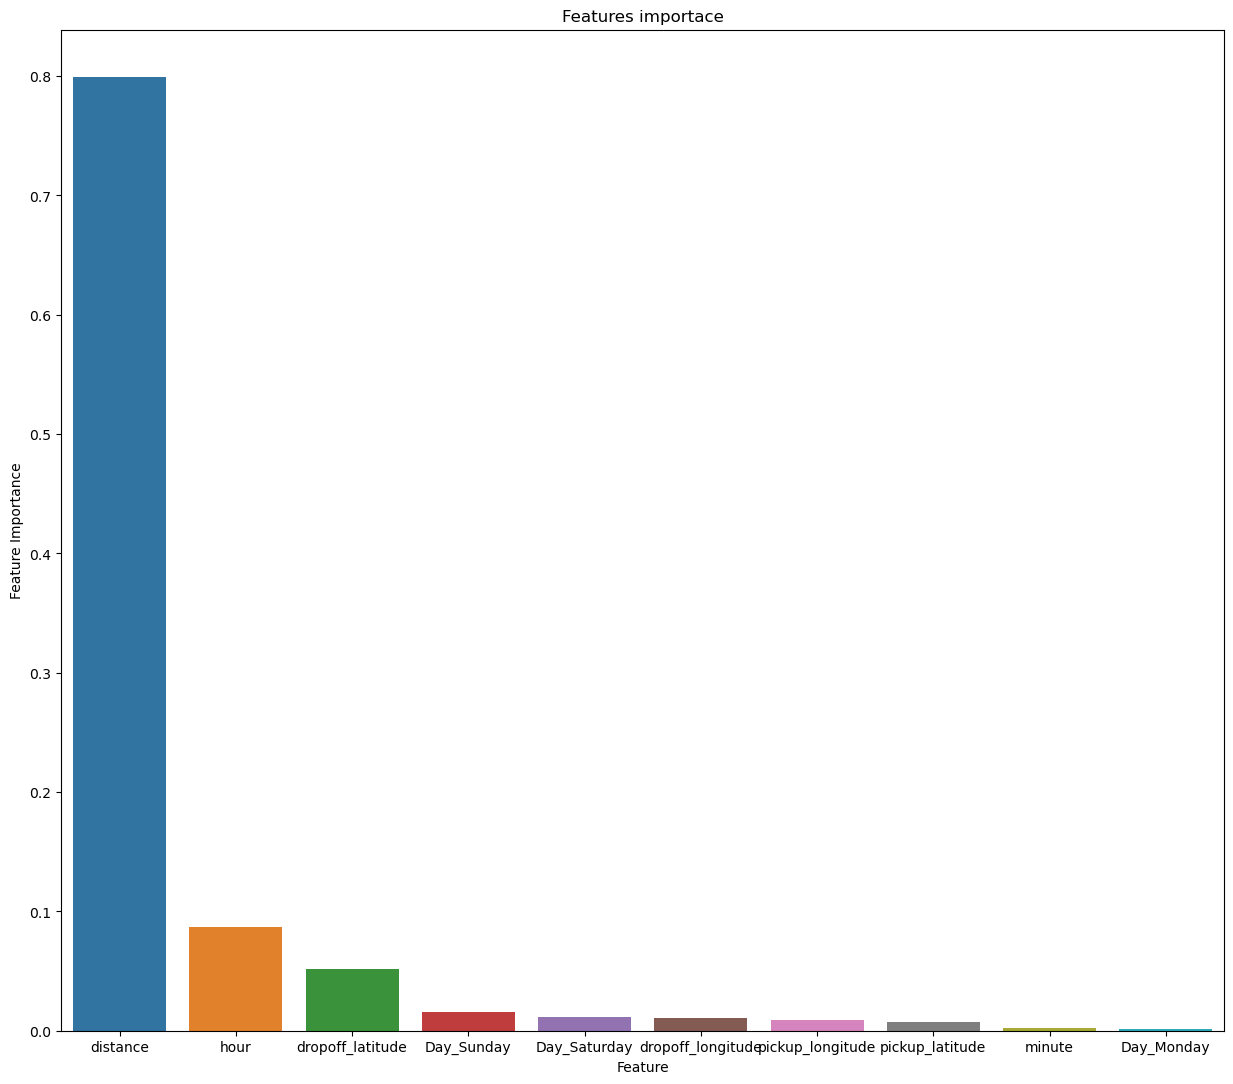

In [88]:
plt.figure(figsize=(15,13))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

In [89]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree

### Lasso Regression

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [90]:
from sklearn.model_selection import GridSearchCV
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.586e+00, tolerance: 6.936e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.543e+00, tolerance: 6.942e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.478e+00, toler

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [91]:
lasso_regressor.score(X_train, y_train)

0.5007103419071957

In [92]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  0.5003166347149017


In [93]:
y_pred_lasso = lasso_regressor.predict(X_test)
y_pred_lasso_train = lasso_regressor.predict(X_train)

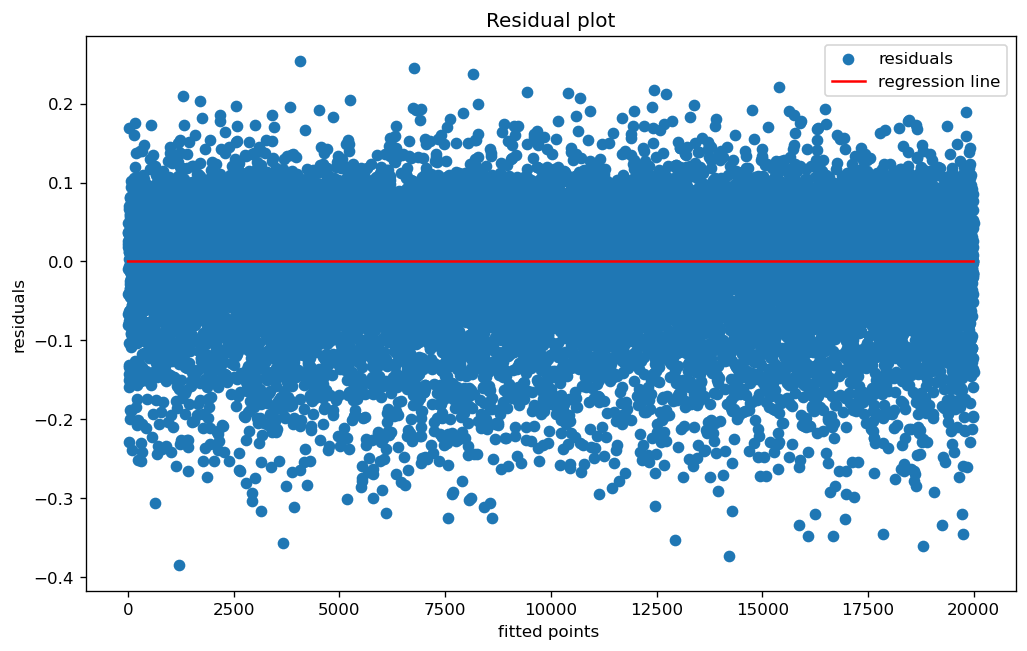

In [94]:
#Heteroskedasticity
residuals=y_pred_lasso-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

MSE : 0.0054 RMSE : 0.07348469228349534
R2 : 0.5007103419071957 Adjusted R2 : 0.500591730960662


(0.0054, 0.07348469228349534, 0.5007103419071957, 0.500591730960662)

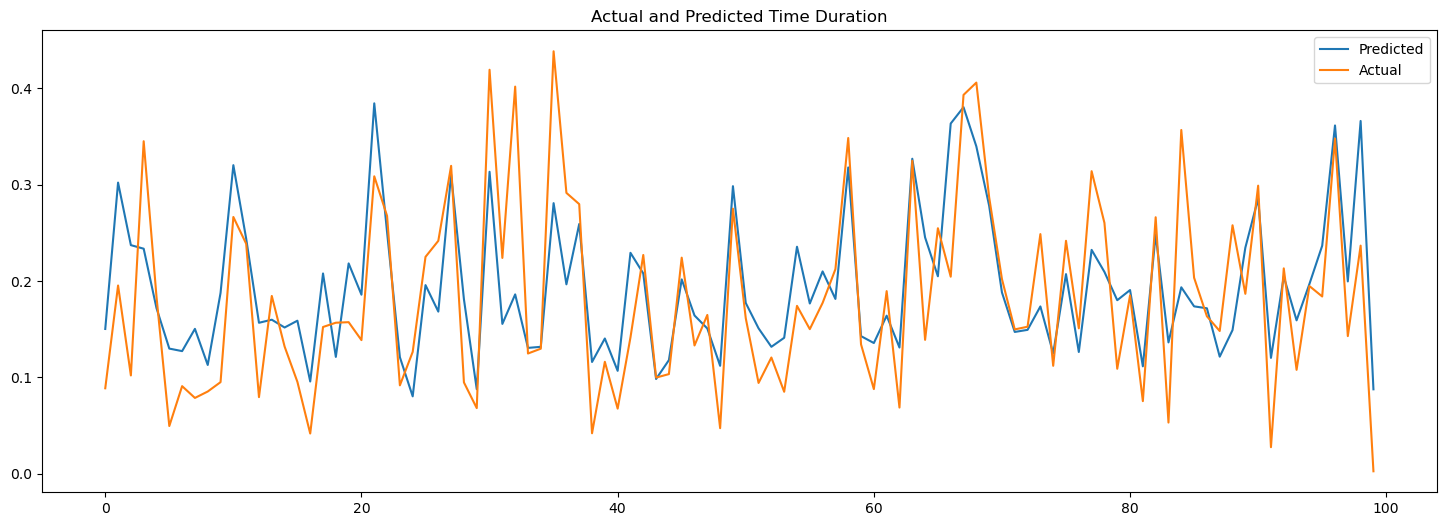

In [95]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_lasso_train)

MSE : 0.0056 RMSE : 0.07483314773547883
R2 : 0.4972820975544002 Adjusted R2 : 0.4968040374870095


(0.0056, 0.07483314773547883, 0.4972820975544002, 0.4968040374870095)

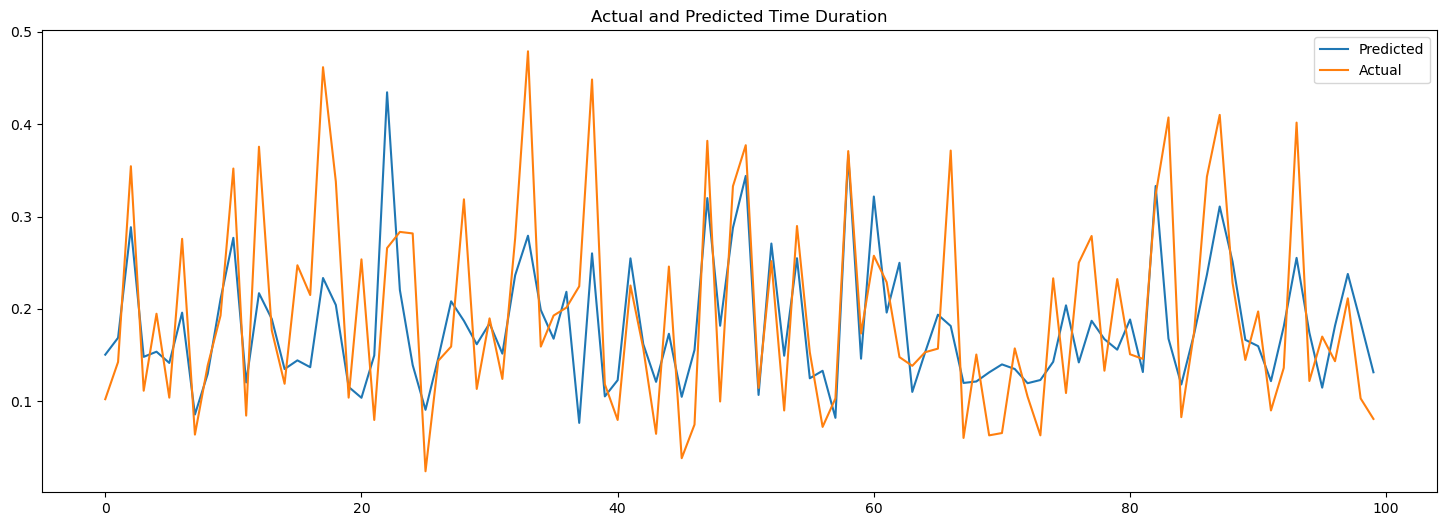

In [96]:
#Evaluation metrics for Test set
EvaluationMetric(X_test,y_test,y_pred_lasso)

### Ridge Regression

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. Here the highlighted part represents L2 regularization element.

In [97]:
from sklearn.linear_model import Ridge
### Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.54137e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.54137e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.26692e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [98]:
ridge_regressor.score(X_train, y_train)

0.5007102132033261

In [99]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 55}

Using  {'alpha': 55}  the negative mean squared error is:  0.5003166347149017


In [100]:
y_pred_ridge_test = ridge_regressor.predict(X_test)
y_pred_ridge_train=ridge_regressor.predict(X_train)

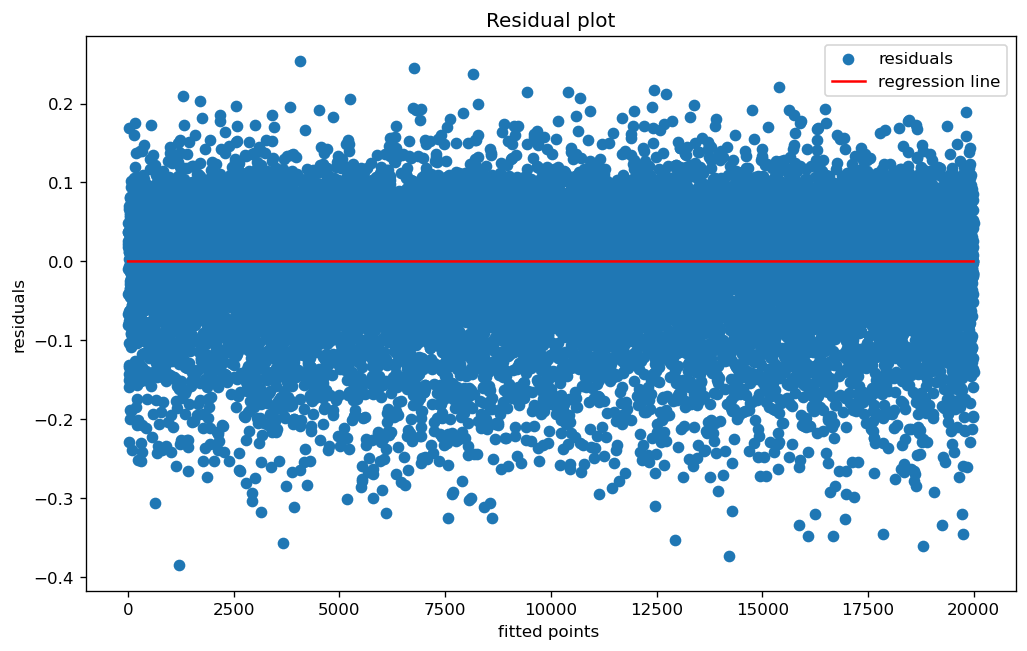

In [101]:
#Heteroskedasticity
residuals=y_pred_ridge_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

MSE : 0.0054 RMSE : 0.07348469228349534
R2 : 0.5007102132033261 Adjusted R2 : 0.5005916022262176


(0.0054, 0.07348469228349534, 0.5007102132033261, 0.5005916022262176)

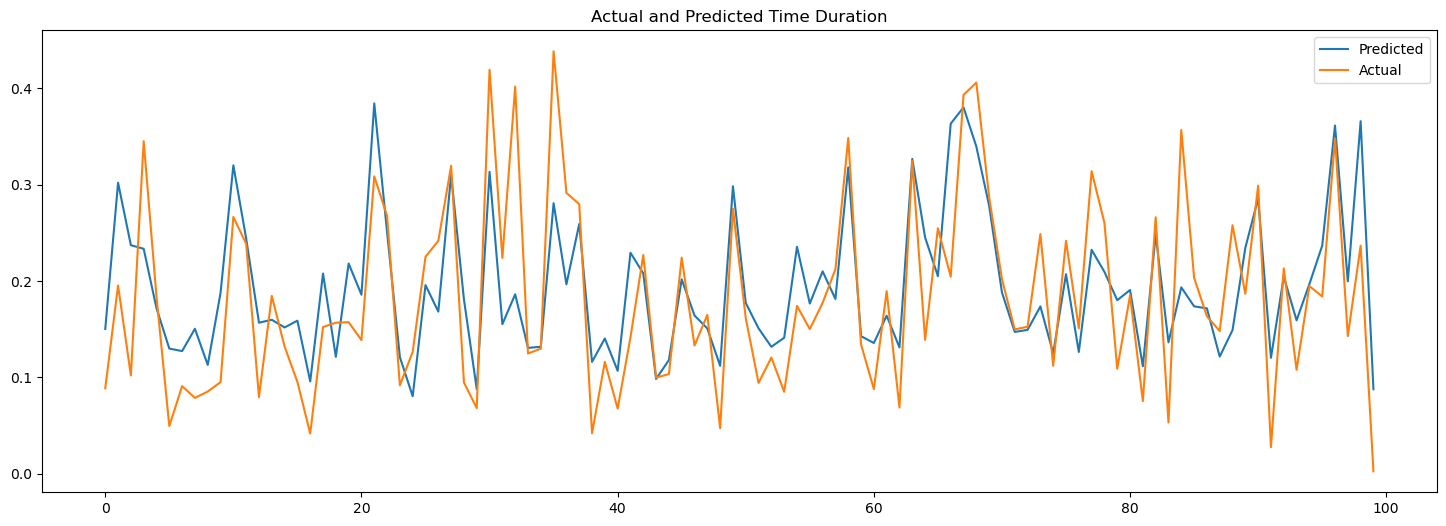

In [102]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_ridge_train)

MSE : 0.0056 RMSE : 0.07483314773547883
R2 : 0.4972712218631439 Adjusted R2 : 0.4967931514535042


(0.0056, 0.07483314773547883, 0.4972712218631439, 0.4967931514535042)

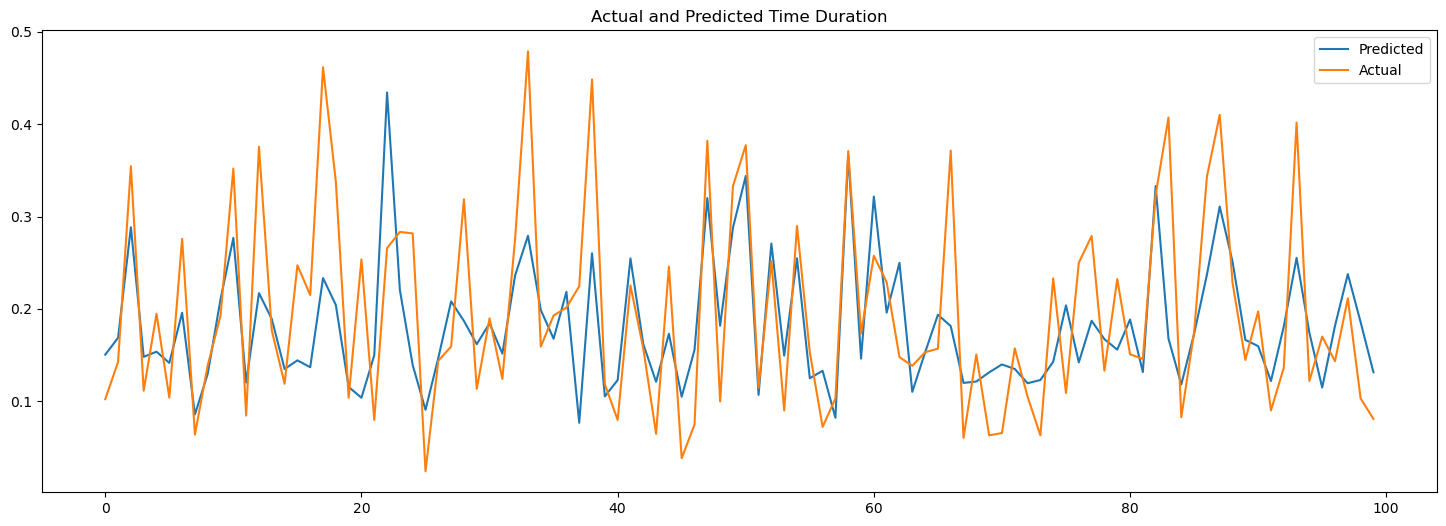

In [103]:
#Evaluation metrics for Test set
EvaluationMetric(X_test,y_test,y_pred_ridge_test)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14152\3813822069.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred_ridge_test ).set_title("error distribution between actual and predicted values")


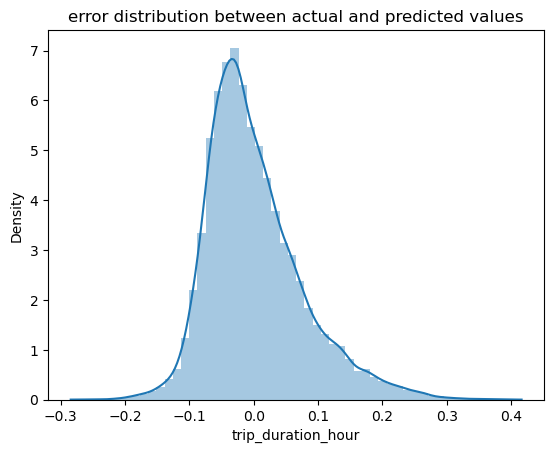

In [104]:
sns.distplot(y_test - y_pred_ridge_test ).set_title("error distribution between actual and predicted values")
plt.show()